In [12]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd
from scipy.fft import fft
import scipy.signal as signal
from math import log10
from scipy.fft import fft, fftfreq
from scipy.signal import lfilter, find_peaks
import pywt

**EN REPOSO**


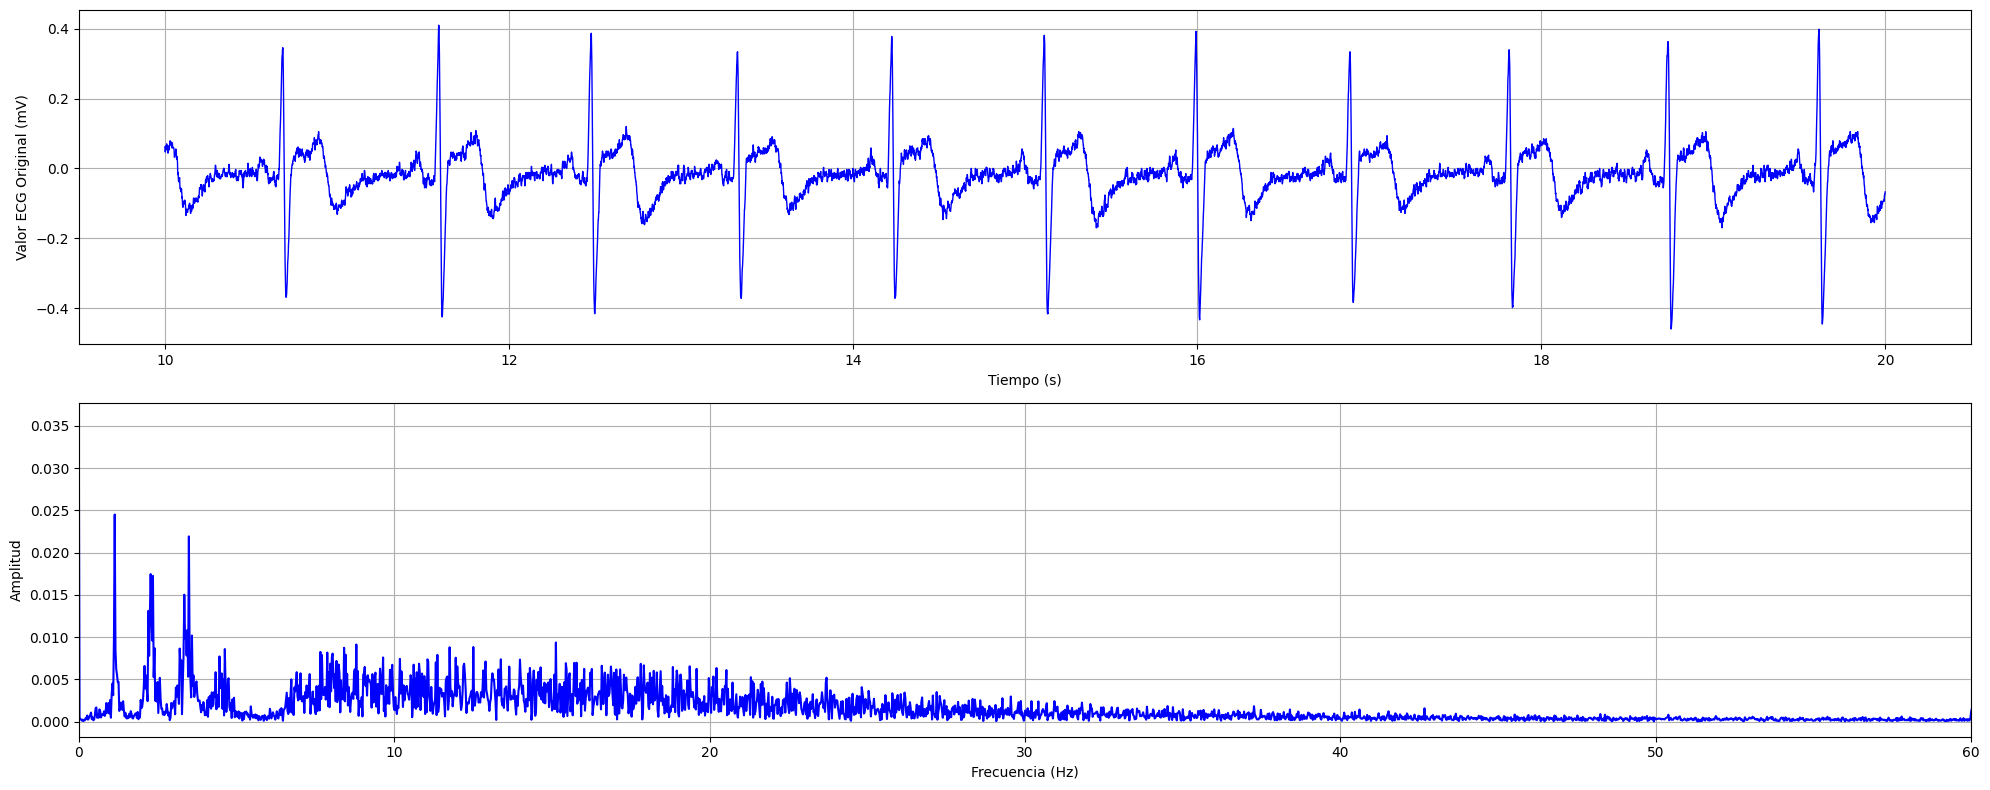

In [57]:
# leyendo archivo texto
archivo_txt = "NormalBreath30s.txt"
datos_ecg = np.loadtxt(archivo_txt)
data = datos_ecg[:, 5]  # Sexta columna

# arreglo para los tiempos
frecuencia_muestreo = 1000
tiempo = np.arange(len(data)) / frecuencia_muestreo

# Intervalo de tiempo que visualizamos
inicio_segundo = 10
fin_segundo = 20
inicio_muestra = int(inicio_segundo * frecuencia_muestreo)
fin_muestra = int(fin_segundo * frecuencia_muestreo)

# Parámetros del BITalino
resolucion_adc = 1024
rango_voltaje = 3.0  # en mV
offset = resolucion_adc / 2

# Convertir los datos a mV
data_mv = ((data - offset) / resolucion_adc) * rango_voltaje

# Gráficos de las señales filtradas
plt.figure(figsize=(20, 8))
plt.subplot(2,1,1)
plt.plot(tiempo[inicio_muestra:fin_muestra], data_mv[inicio_muestra:fin_muestra], lw=1, color='blue')
plt.xlabel('Tiempo (s)')
plt.ylabel('Valor ECG Original (mV)')
plt.grid(True)

# Análisis en frecuencia con la Transformada de Fourier
N = len(data_mv)
T = 1.0 / frecuencia_muestreo

# Realizar la Transformada de Fourier
yf = fft(data_mv)
xf = fftfreq(N, T)[:N//2]

# Gráfica del espectro de frecuencias
plt.subplot(2,1,2)
plt.plot(xf, 2.0/N * np.abs(yf[:N//2]), color='blue')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Amplitud')
plt.grid(True)
plt.xlim(0, 60)  # Limitar el eje x de 0 a 60 Hz
plt.tight_layout()
plt.show()

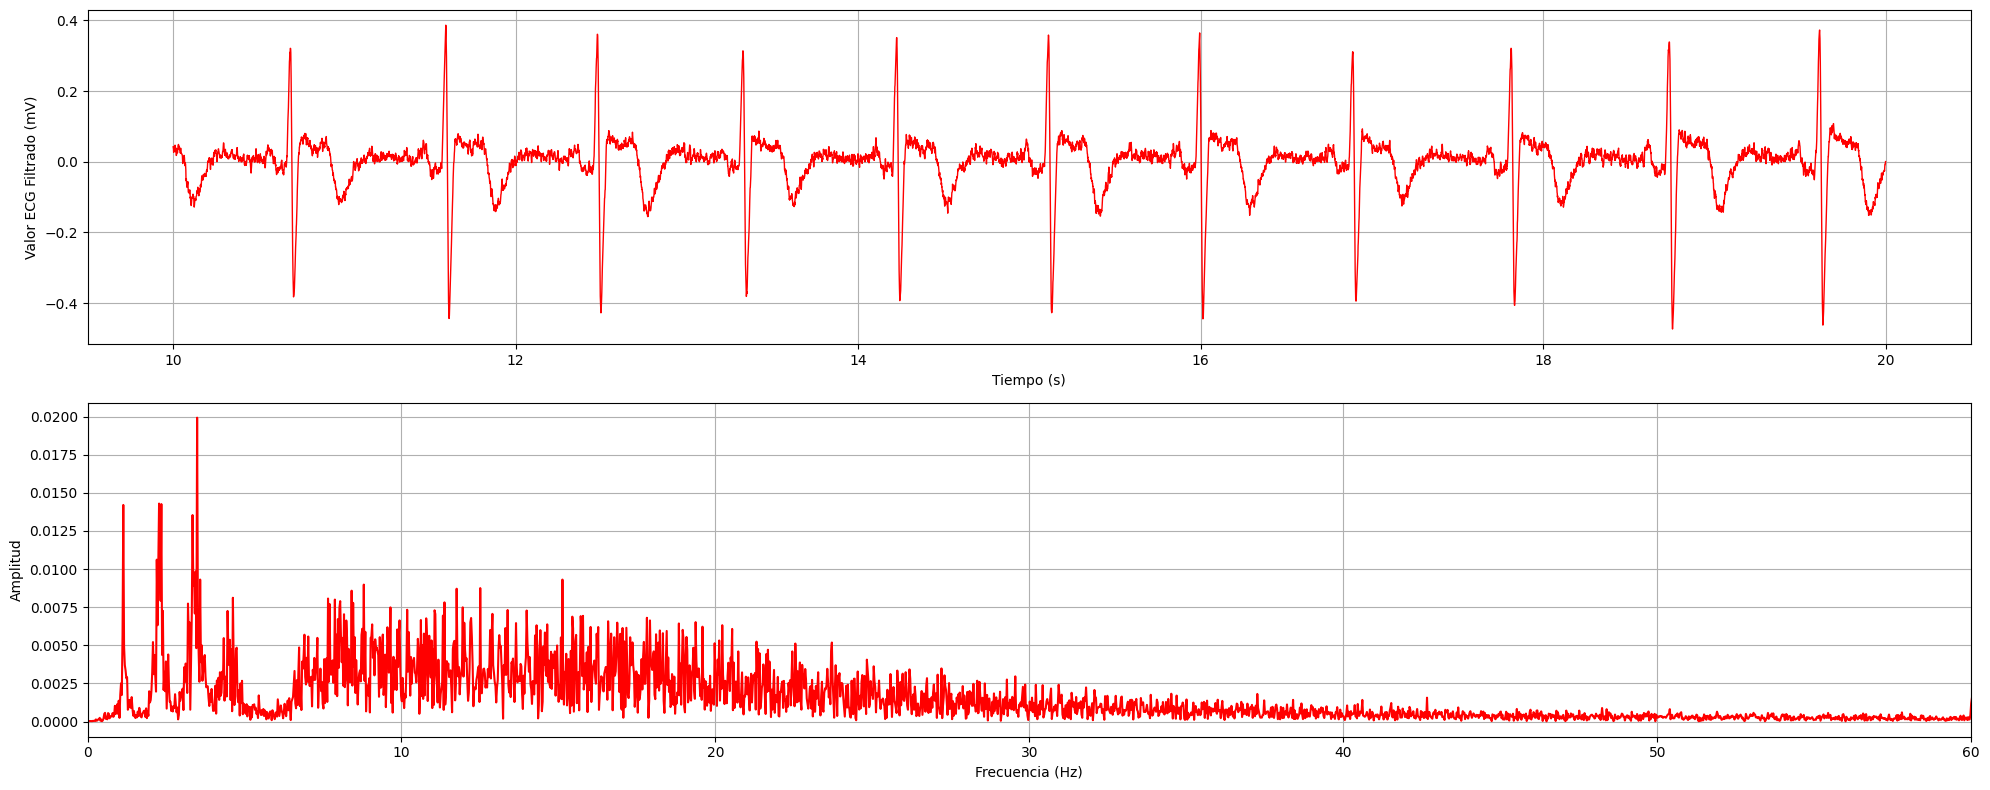

In [58]:
# Aplicar filtro pasa altas DC-notch IIR de primer orden
alpha = 0.99
b = [(1 + alpha) / 2, -(1 + alpha) / 2]  # Coeficientes del numerador
a = [1, -alpha]  # Coeficientes del denominador

# Filtrar la señal
data_filtered = lfilter(b, a, data_mv)

# Gráficos de las señales filtradas
plt.figure(figsize=(20, 8))

plt.subplot(2,1,1)
plt.plot(tiempo[inicio_muestra:fin_muestra], data_filtered[inicio_muestra:fin_muestra], lw=1, color='red')
plt.xlabel('Tiempo (s)')
plt.ylabel('Valor ECG Filtrado (mV)')
plt.grid(True)

# Realizar la Transformada de Fourier
yf1 = fft(data_filtered)
xf1 = fftfreq(N, T)[:N//2]

# Gráfica del espectro de frecuencias
plt.subplot(2,1,2)
plt.plot(xf1, 2.0/N * np.abs(yf1[:N//2]), color='red')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Amplitud')
plt.grid(True)
plt.xlim(0, 60)  # Limitar el eje x de 0 a 60 Hz
plt.tight_layout()
plt.show()


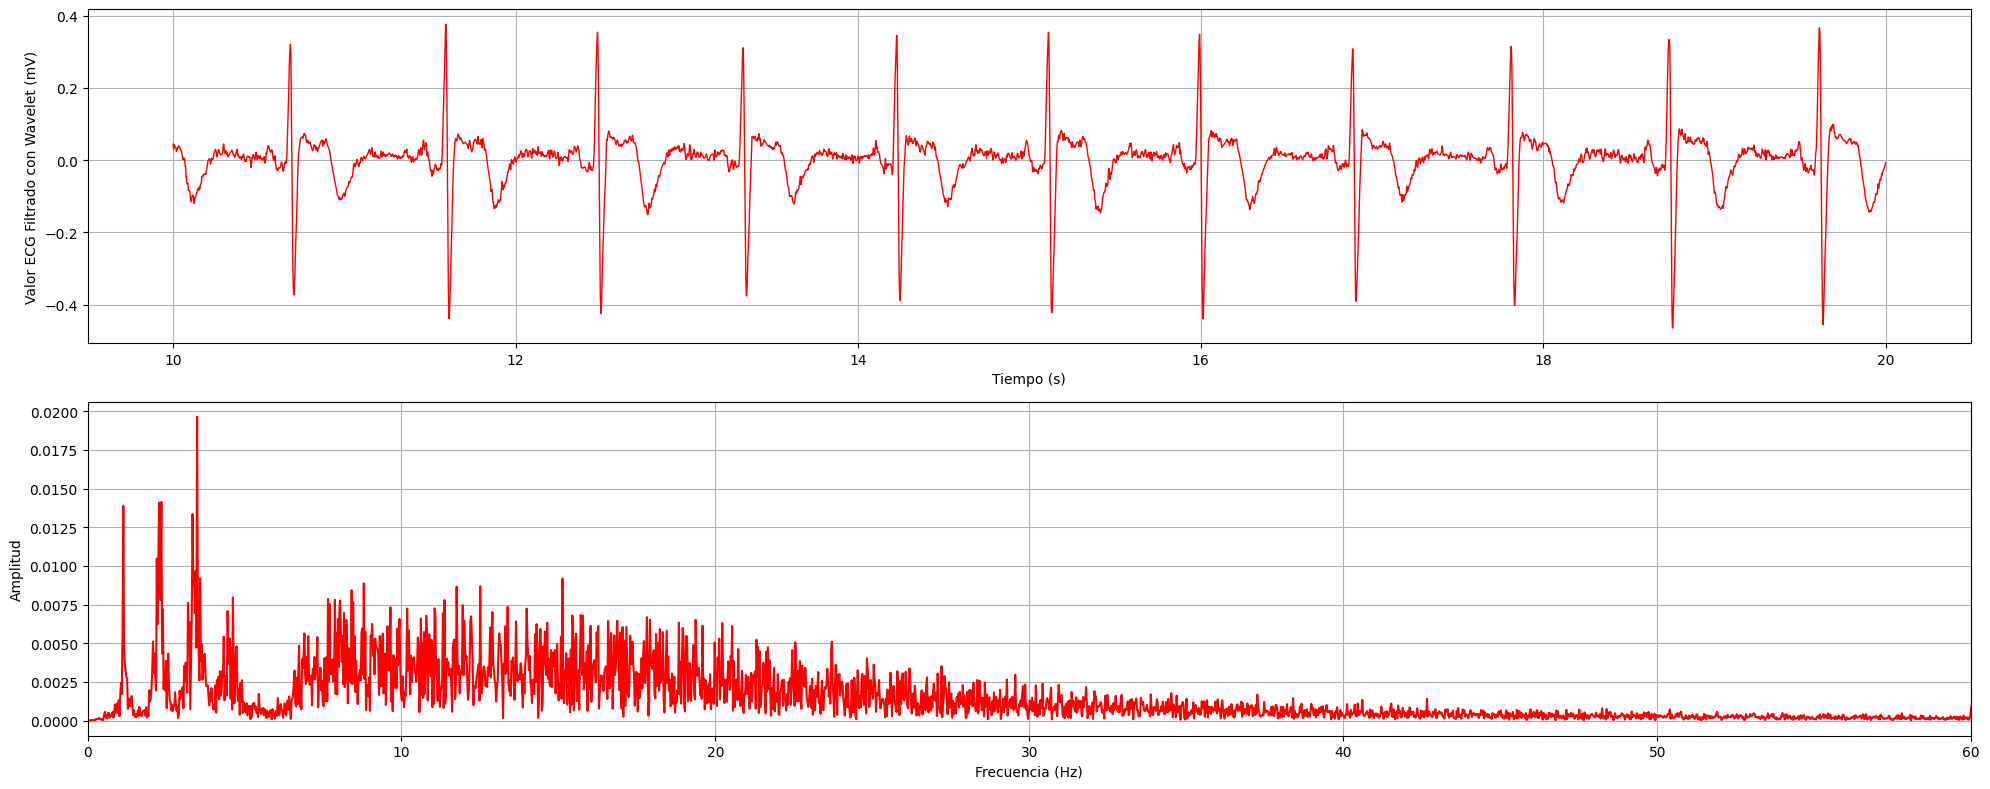

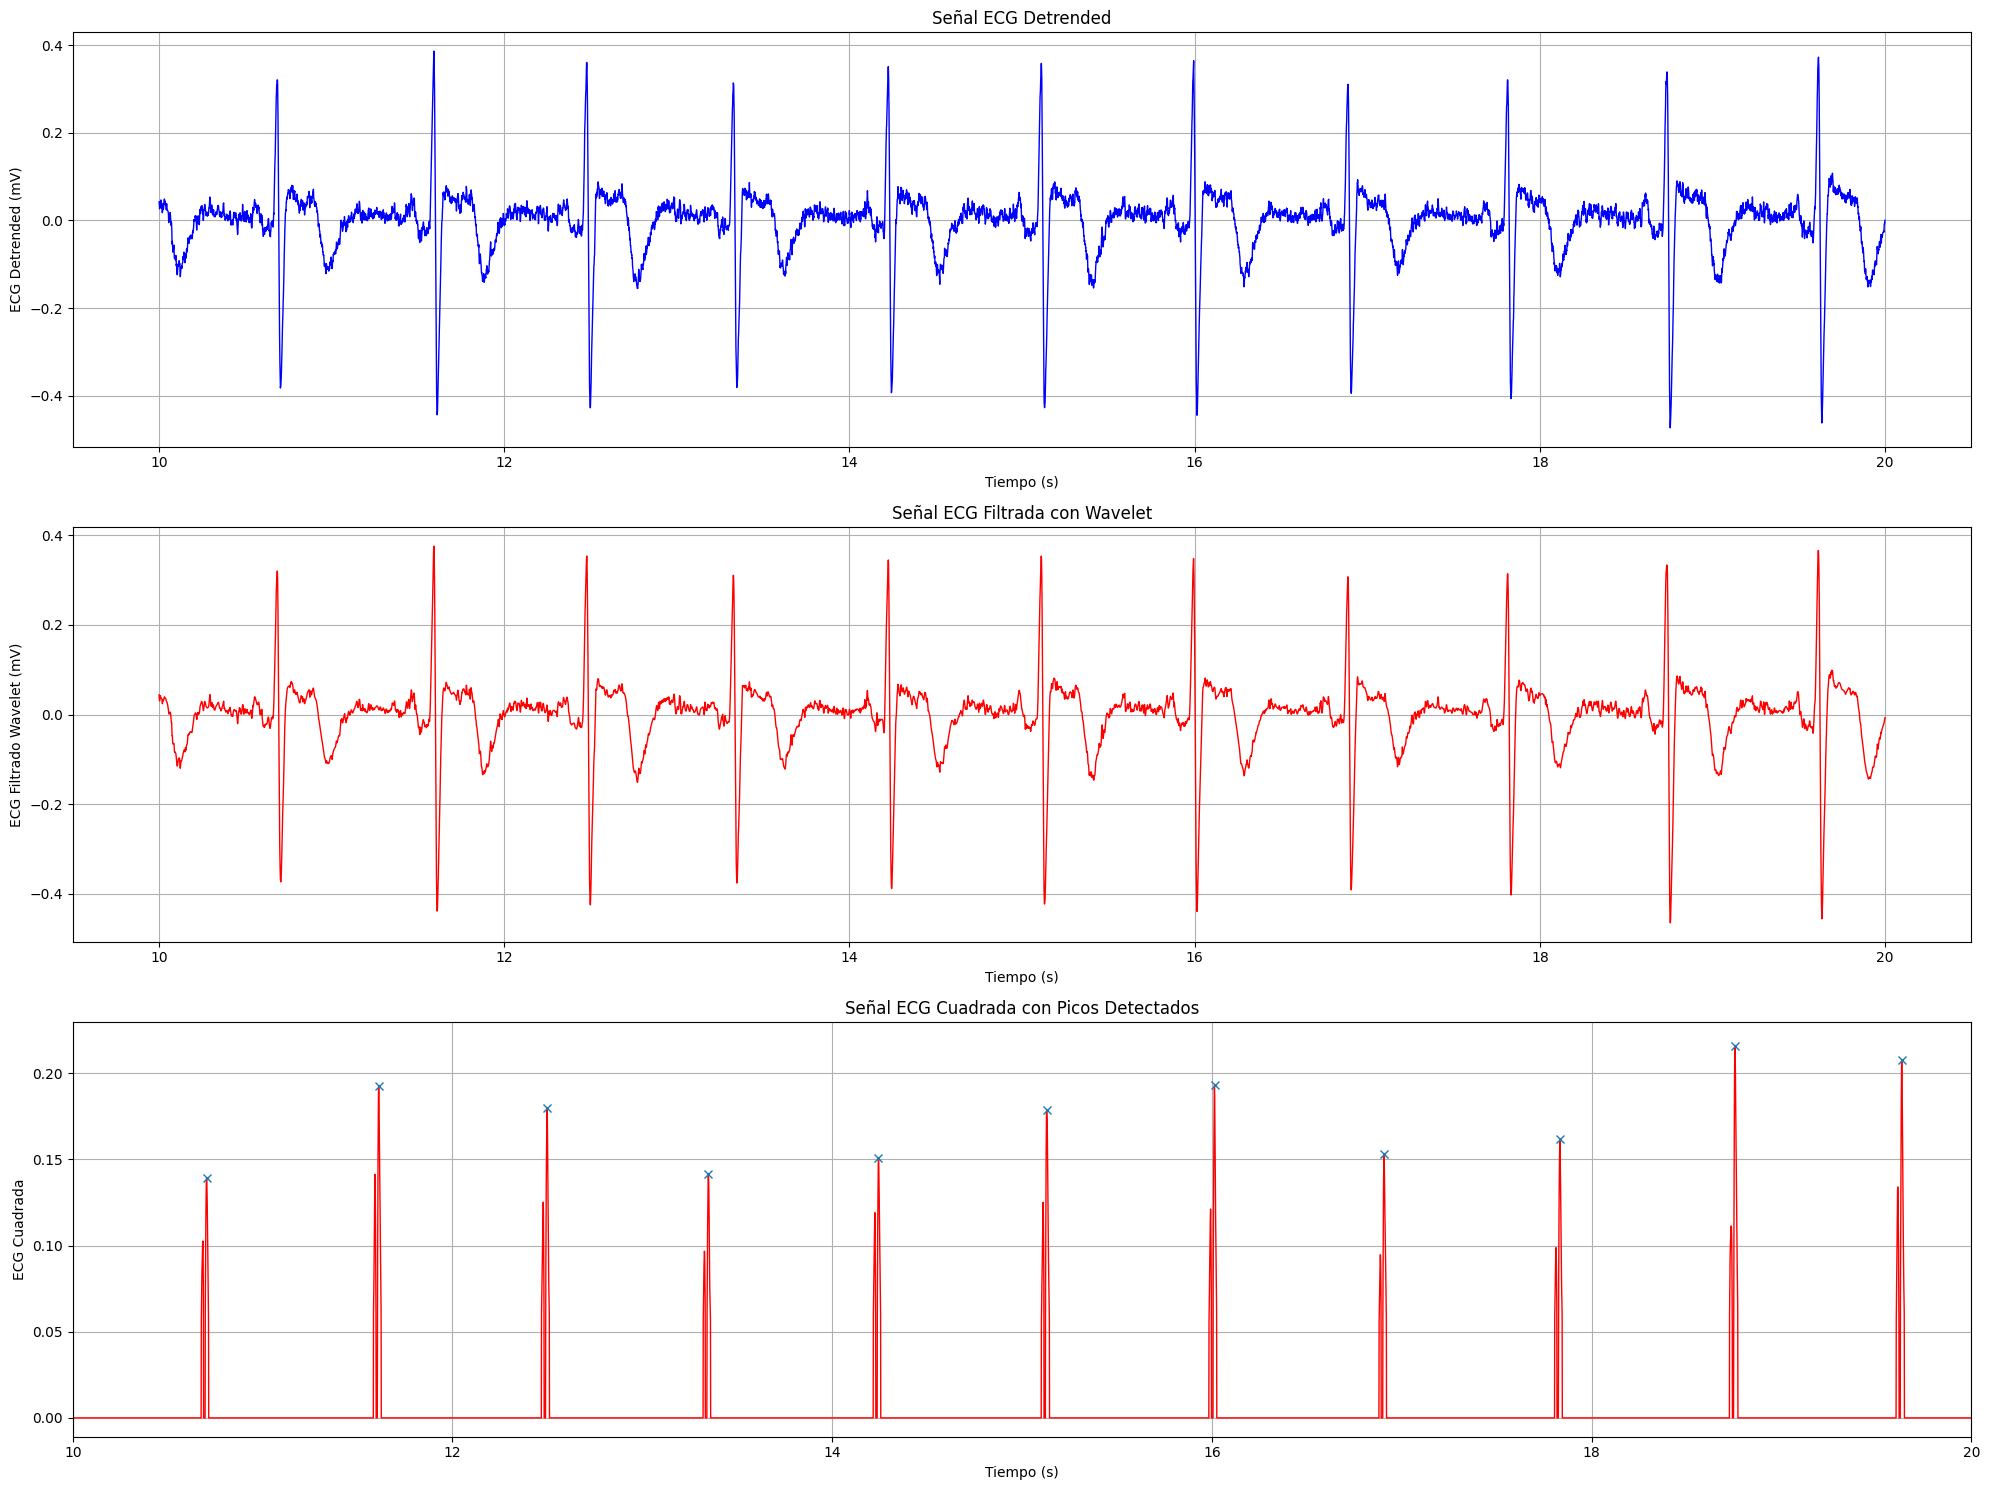

In [59]:
# Aplicar la Transformada Wavelet Discreta (DWT) usando Daubechies-6 (db6)
coeffs = pywt.wavedec(data_filtered, 'db6', mode='per')

# Umbral adaptativo para atenuar sub-bandas de alta frecuencia
umbral_adaptativo = np.std(coeffs[-1]) * 2.5  # factor multiplicativo para que salga bonito :) text dice que lo ajuste
coeffs_filt = [pywt.threshold(c, umbral_adaptativo, mode='soft') for c in coeffs]

# Reconstruir la señal filtrada
data_wavelet_filtered = pywt.waverec(coeffs_filt, 'db6', mode='per')

# Gráficos de las señales filtradas
plt.figure(figsize=(20, 8))
plt.subplot(2,1,1)
plt.plot(tiempo[inicio_muestra:fin_muestra], data_wavelet_filtered[inicio_muestra:fin_muestra], lw=1, color='red')
plt.xlabel('Tiempo (s)')
plt.ylabel('Valor ECG Filtrado con Wavelet (mV)')
plt.grid(True)

# Realizar la Transformada de Fourier
yf2 = fft(data_wavelet_filtered)
xf2 = fftfreq(N, T)[:N//2]

# Gráfica del espectro de frecuencias
plt.subplot(2,1,2)
plt.plot(xf2, 2.0/N * np.abs(yf2[:N//2]), color='red')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Amplitud')
plt.grid(True)
plt.xlim(0, 60)  # Limitar el eje x de 0 a 60 Hz

plt.tight_layout()
plt.show()


# square de la señal
data_squared = np.square(data_wavelet_filtered)

# Aplicar umbral adaptativo
umbral_aplicado = np.max(data_squared) * 0.25  # Por ejemplo, supongamos un umbral del % de la amplitud máxima
data_squared_umbral = data_squared * (data_squared > umbral_aplicado)

# Detección de picos con umbral adaptativo
peaks, _ = find_peaks(data_squared_umbral, distance=150)  # Ajustar distancia mínima entre picos

# Gráficos de la señal original, filtrada y cuadrada con detección de picos
plt.figure(figsize=(20, 15))

plt.subplot(3, 1, 1)
plt.plot(tiempo[inicio_muestra:fin_muestra], data_filtered[inicio_muestra:fin_muestra], lw=1, color='blue')
plt.xlabel('Tiempo (s)')
plt.ylabel('ECG Detrended (mV)')
plt.title('Señal ECG Detrended')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(tiempo[inicio_muestra:fin_muestra], data_wavelet_filtered[inicio_muestra:fin_muestra], lw=1, color='red')
plt.xlabel('Tiempo (s)')
plt.ylabel('ECG Filtrado Wavelet (mV)')
plt.title('Señal ECG Filtrada con Wavelet')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(tiempo[inicio_muestra:fin_muestra], data_squared_umbral[inicio_muestra:fin_muestra], lw=1, color='red')
plt.plot(tiempo[peaks], data_squared_umbral[peaks], "x")
plt.xlabel('Tiempo (s)')
plt.ylabel('ECG Cuadrada')
plt.title('Señal ECG Cuadrada con Picos Detectados')
plt.grid(True)
plt.xlim(10, 20)

plt.tight_layout()
plt.show()



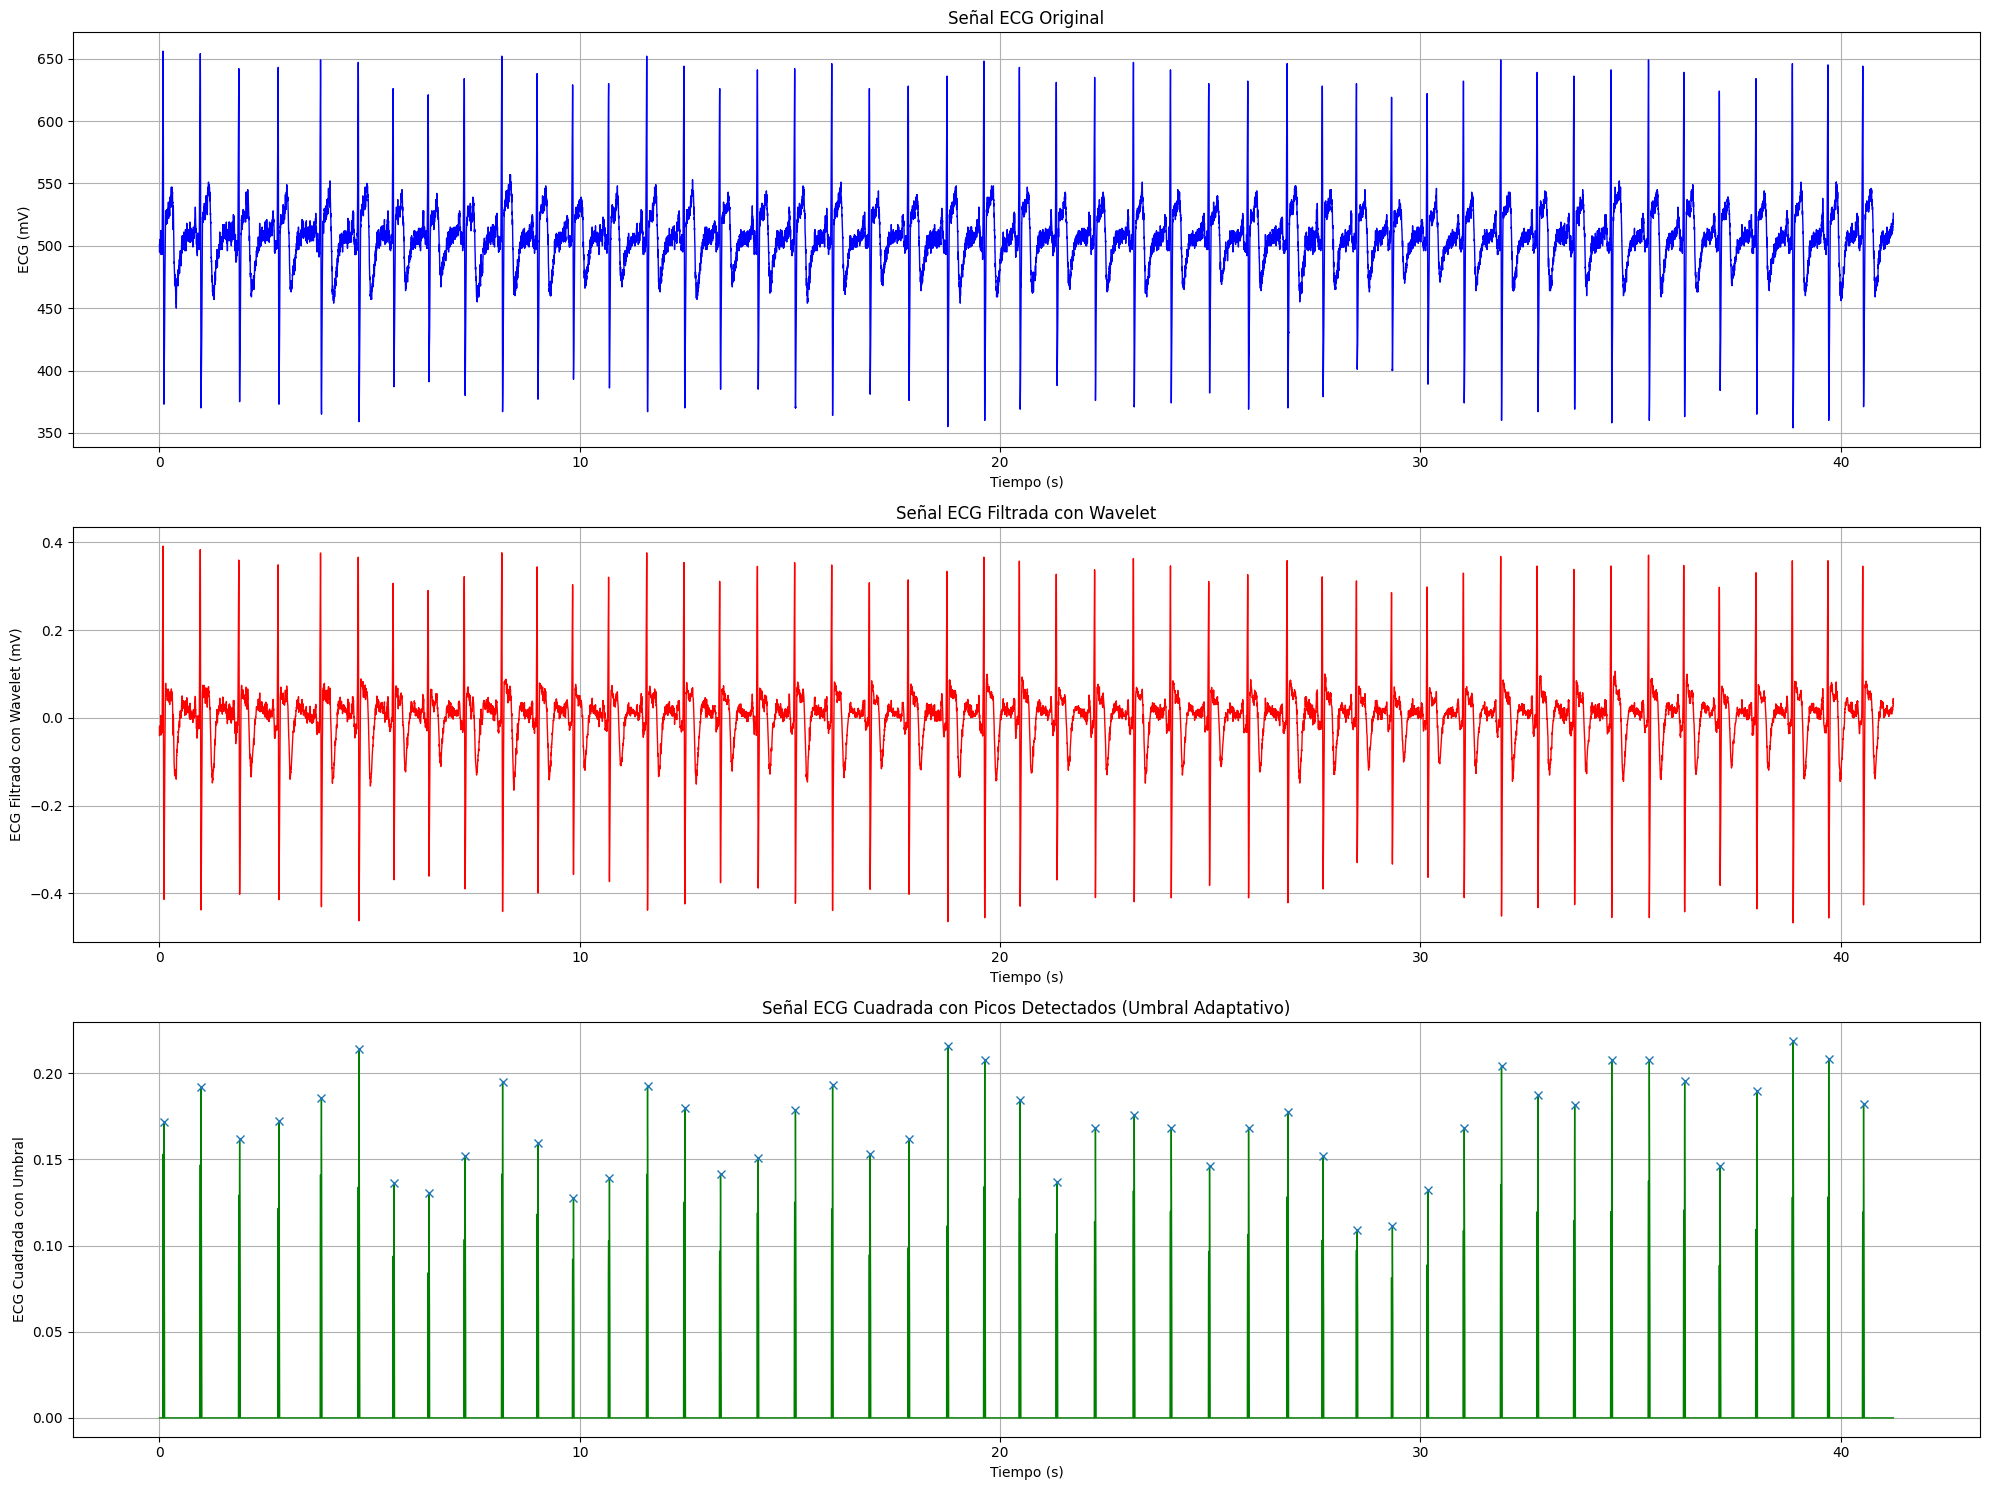

In [60]:
# Cálculo de la señal de intervalos RR
RR_intervals = np.diff(peaks) / frecuencia_muestreo

# Cálculo de HRV utilizando cubic spline interpolation
tiempo_interpolado = np.arange(tiempo[0], tiempo[-1], 1 / frecuencia_muestreo)
RR_interpolado = np.interp(tiempo_interpolado, tiempo[peaks[:-1]], RR_intervals)
HRV = np.diff(RR_interpolado)

# Gráficos de la señal original, filtrada y cuadrada con detección de picos
plt.figure(figsize=(20, 15))
plt.subplot(3, 1, 1)
plt.plot(tiempo, data, lw=1, color='blue')
plt.xlabel('Tiempo (s)')
plt.ylabel('ECG (mV)')
plt.title('Señal ECG Original')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(tiempo, data_wavelet_filtered, lw=1, color='red')
plt.xlabel('Tiempo (s)')
plt.ylabel('ECG Filtrado con Wavelet (mV)')
plt.title('Señal ECG Filtrada con Wavelet')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(tiempo, data_squared_umbral, lw=1, color='green')
plt.plot(tiempo[peaks], data_squared_umbral[peaks], "x")
plt.xlabel('Tiempo (s)')
plt.ylabel('ECG Cuadrada con Umbral')
plt.title('Señal ECG Cuadrada con Picos Detectados (Umbral Adaptativo)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [61]:
#ahora para evaluar a la persona
# Calcular RMSSD
RMSSD = np.sqrt(np.mean(np.diff(RR_intervals) ** 2))

# Calcular SDNN
SDNN = np.std(RR_intervals)

# Calcular PNN50
PNN50 = np.sum(np.diff(RR_intervals) > 0.05) / len(RR_intervals) * 100

print("RMSSD:", RMSSD, "s")
print("SDNN:", SDNN, "s")
print("PNN50:", PNN50, "%")

RMSSD: 0.0373538634027474 s
SDNN: 0.0373441626486918 s
PNN50: 4.3478260869565215 %


**AGUANTANDO LA RESPIRACIÓN**


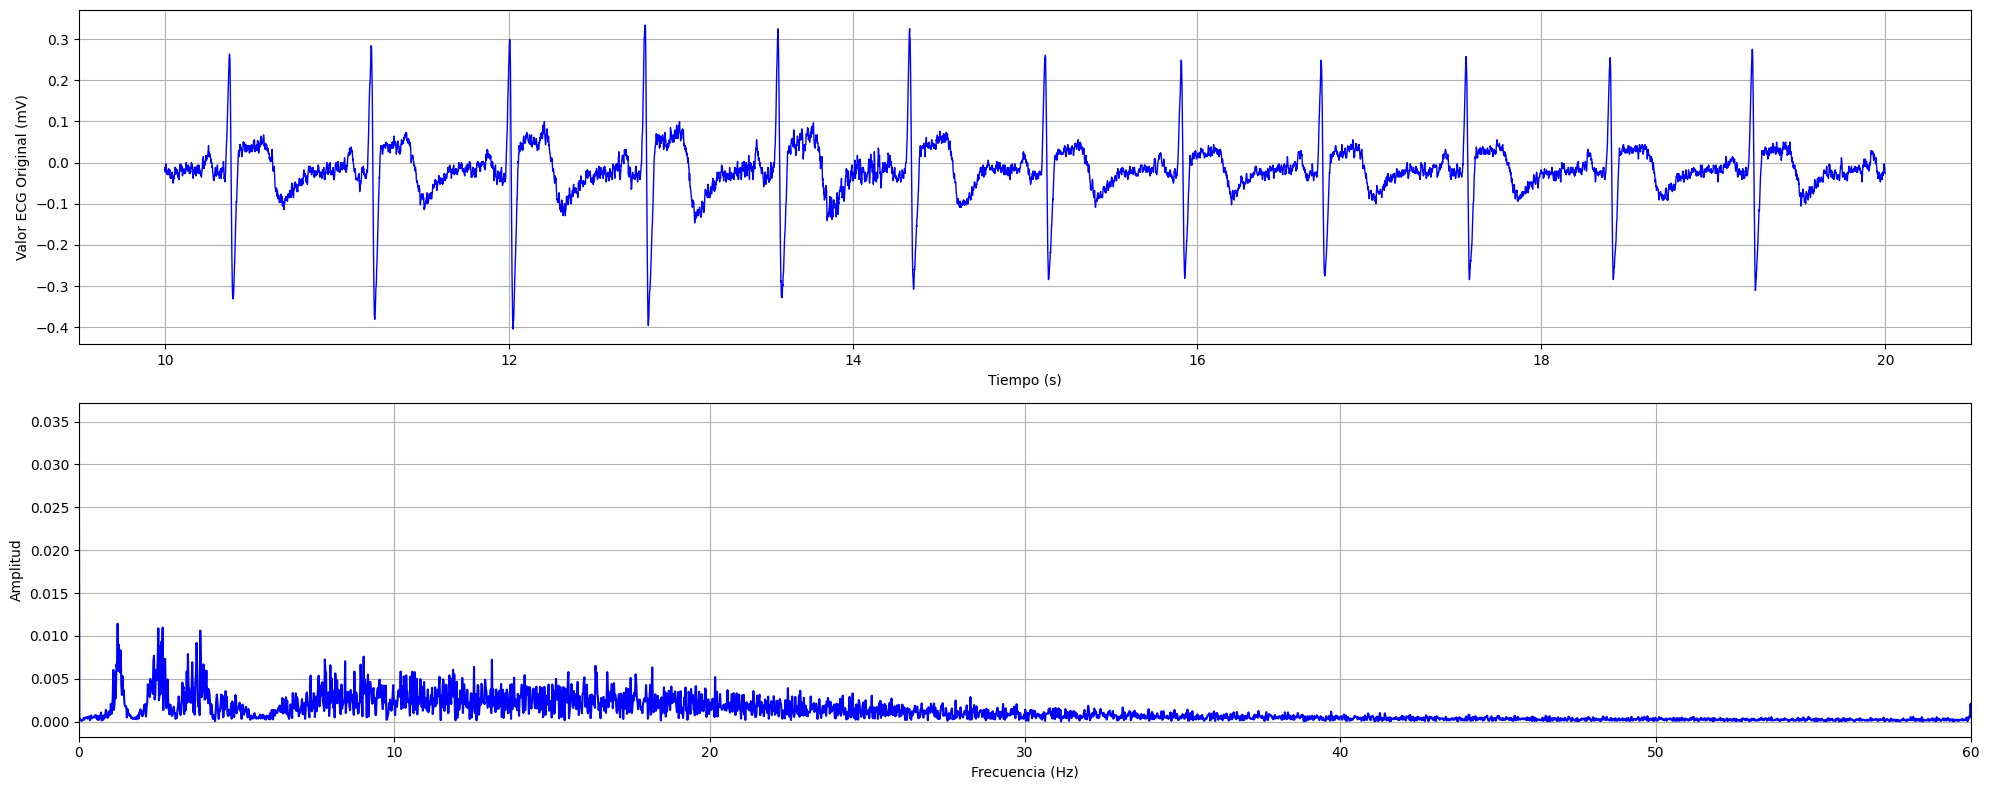

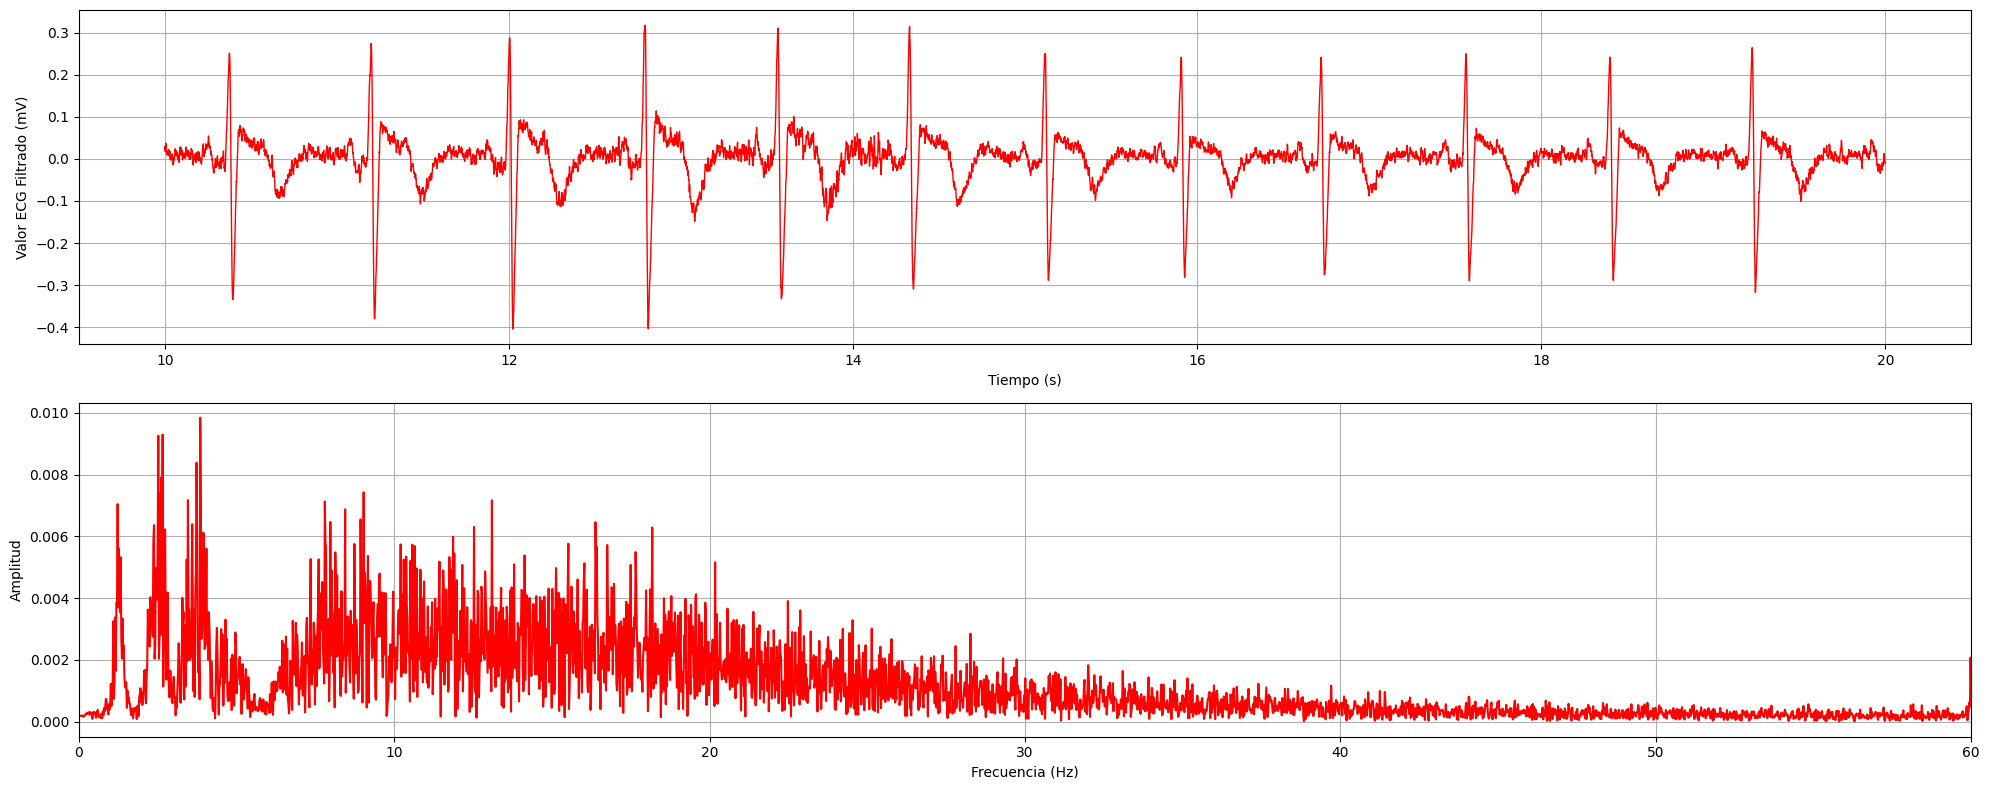

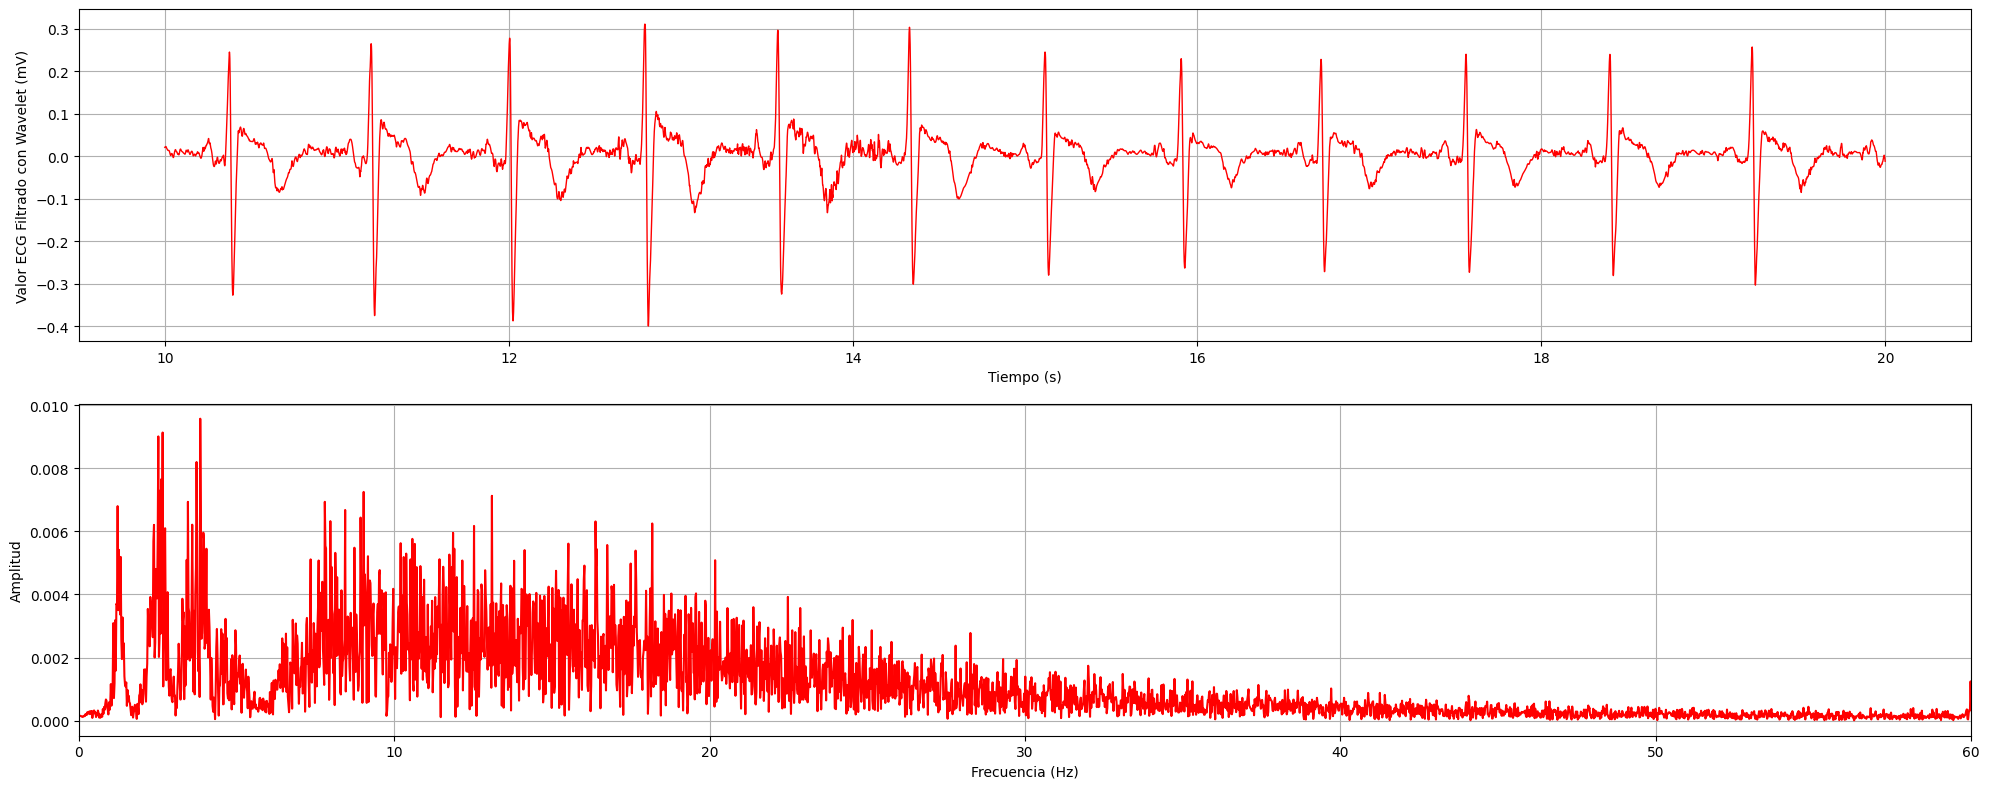

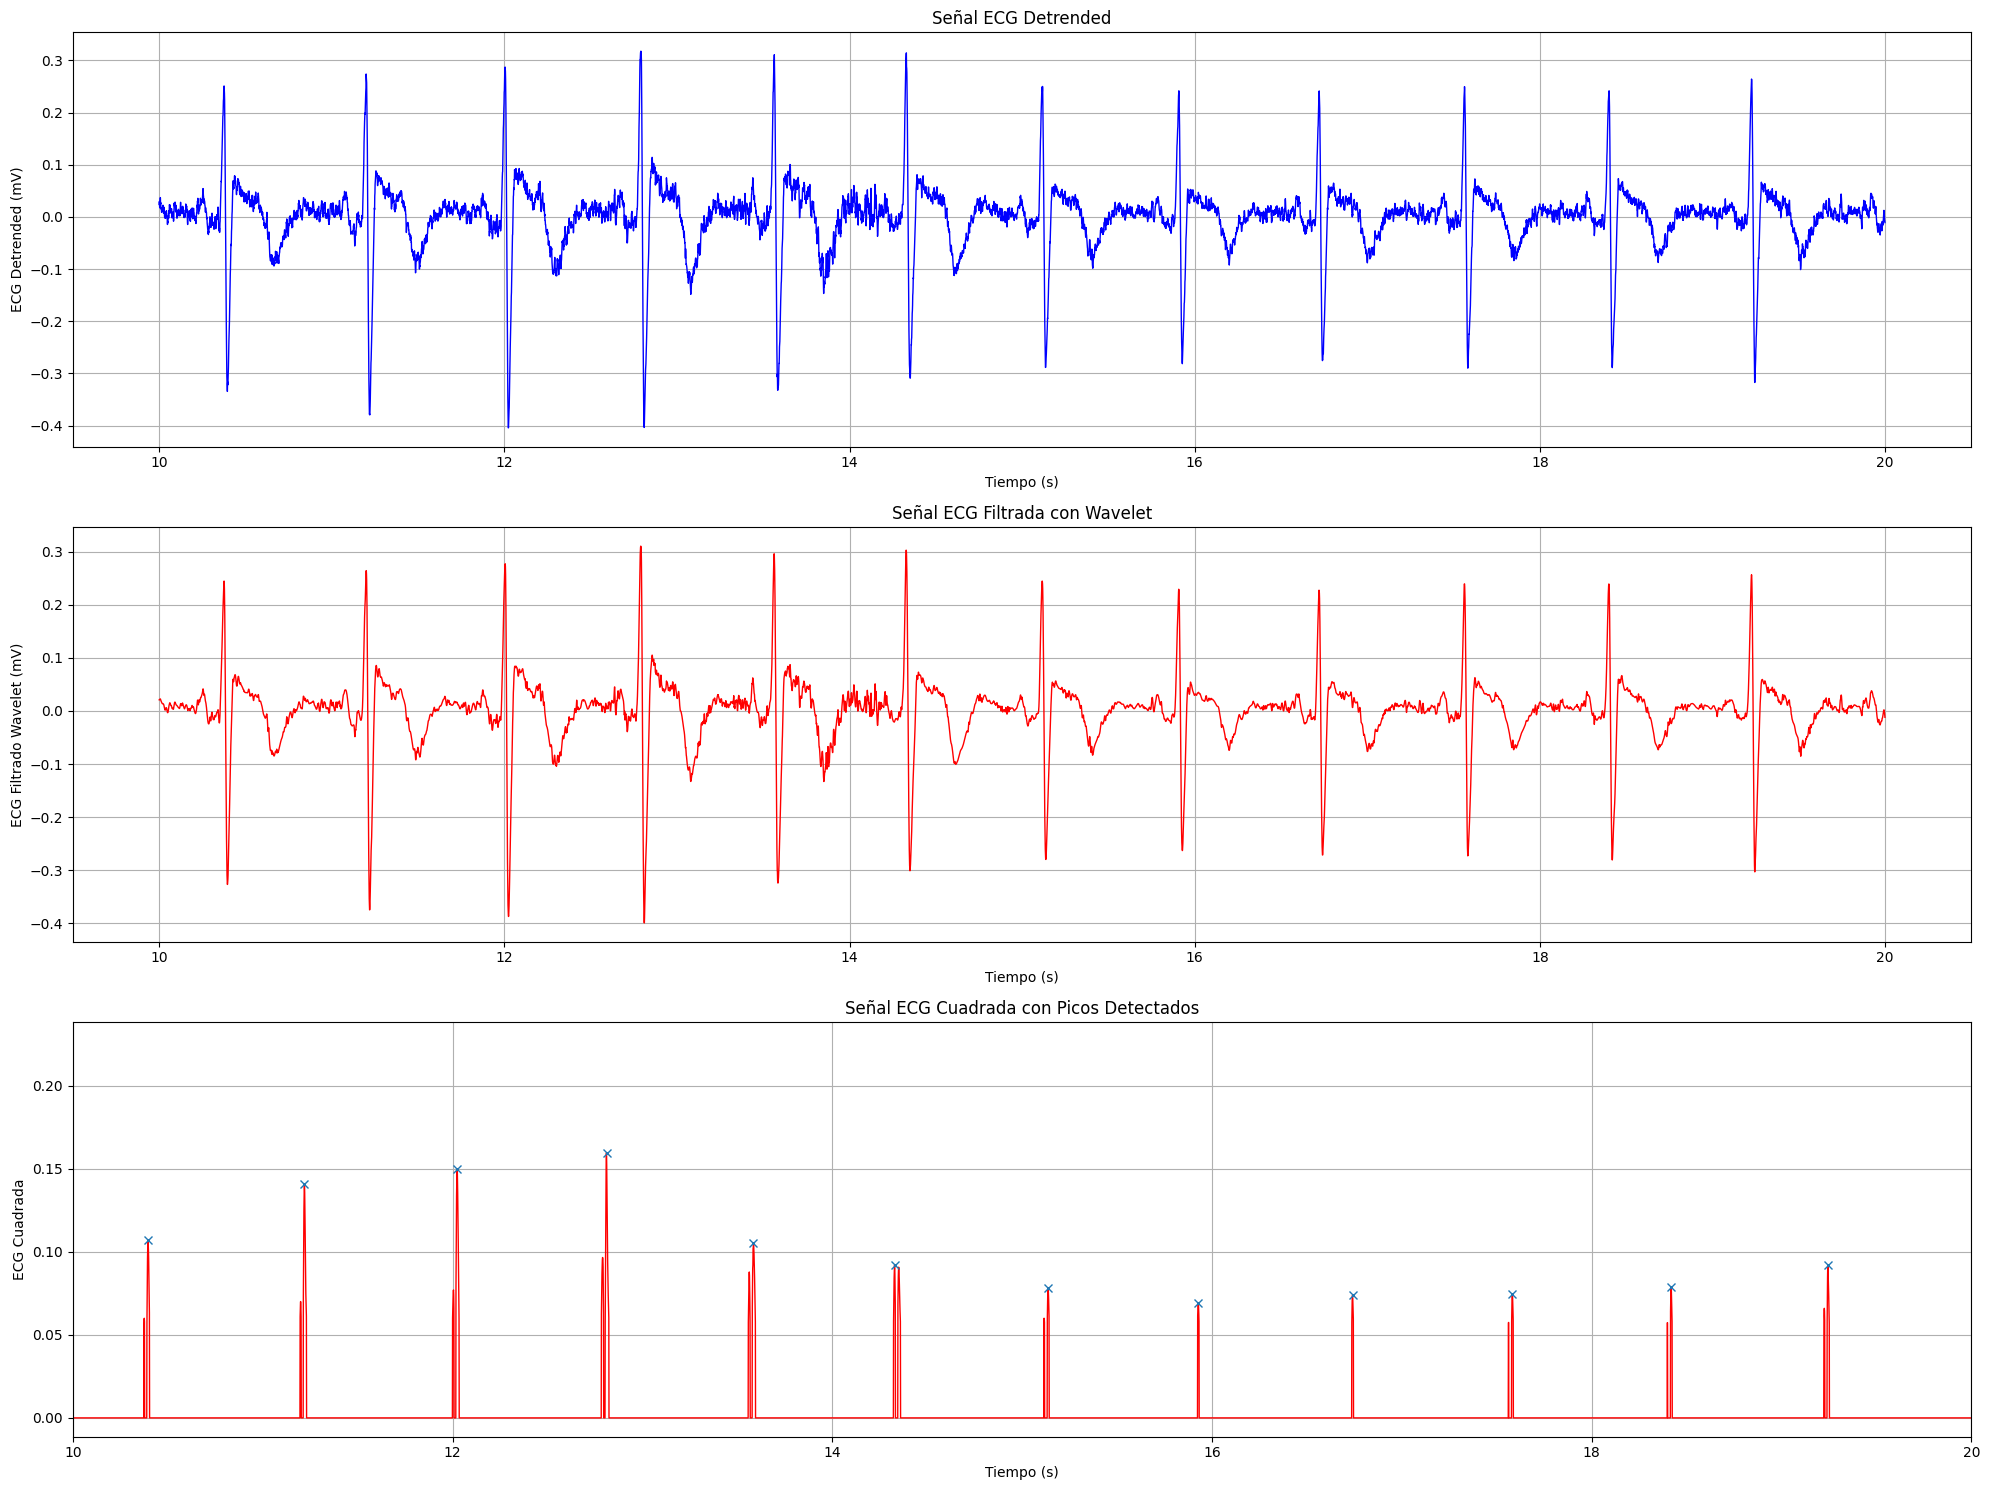

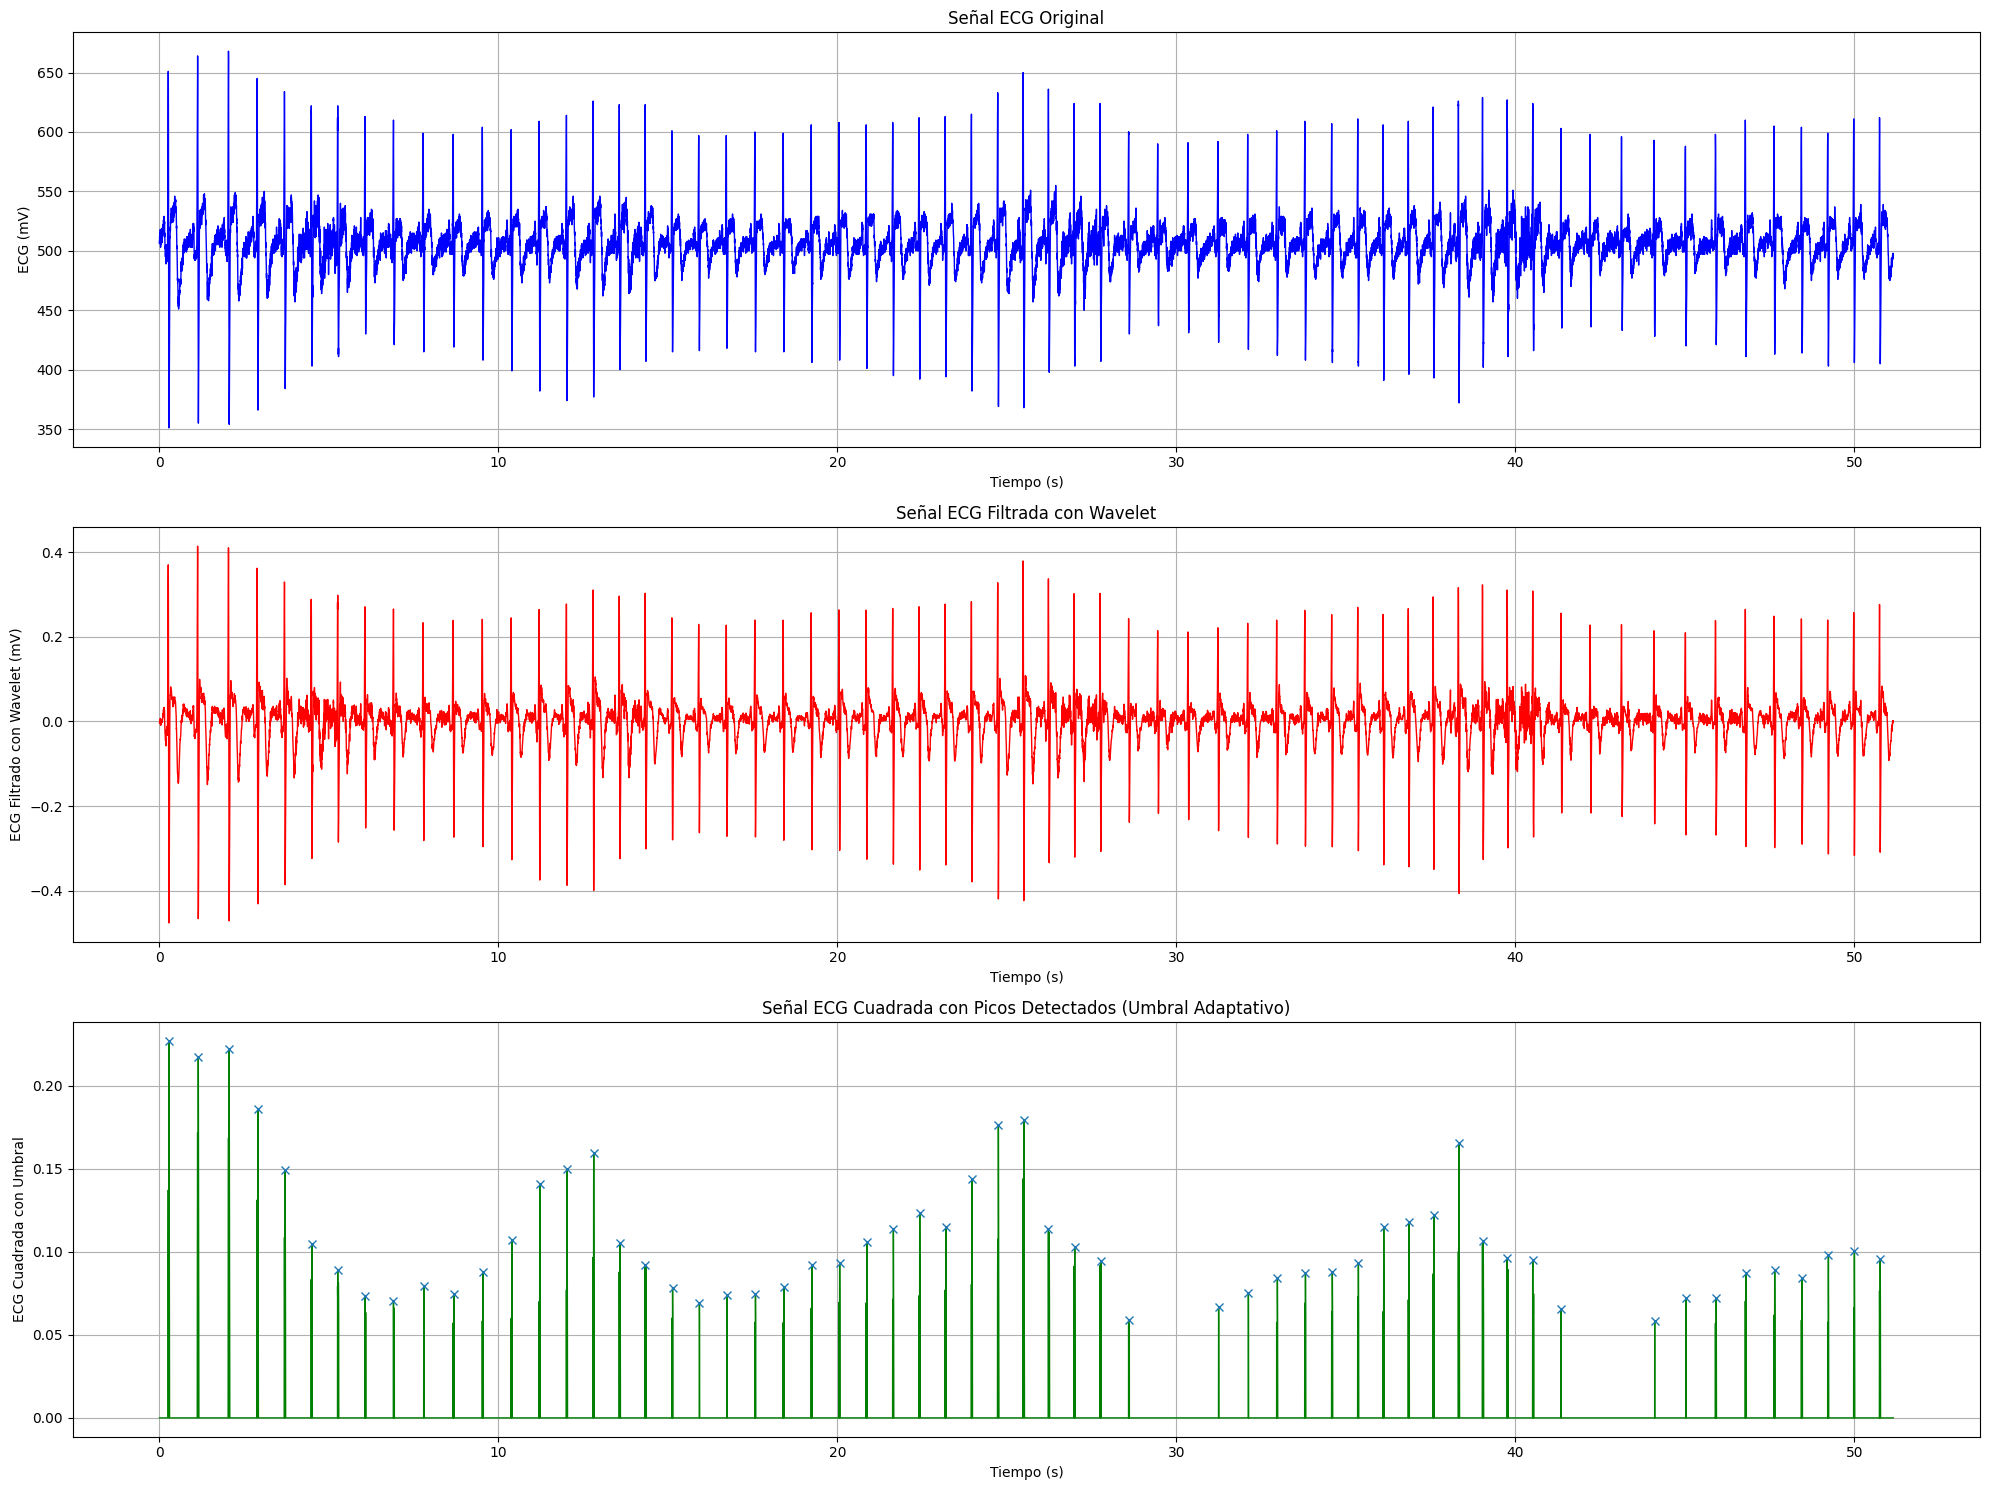

In [53]:
# leyendo archivo texto
archivo_txt = "InHoldEx5s.txt"
datos_ecg = np.loadtxt(archivo_txt)
data = datos_ecg[:, 5]  # Sexta columna

# arreglo para los tiempos
frecuencia_muestreo = 1000
tiempo = np.arange(len(data)) / frecuencia_muestreo

# Intervalo de tiempo que visualizamos
inicio_segundo = 10
fin_segundo = 20
inicio_muestra = int(inicio_segundo * frecuencia_muestreo)
fin_muestra = int(fin_segundo * frecuencia_muestreo)

# Parámetros del BITalino
resolucion_adc = 1024
rango_voltaje = 3.0  # en mV
offset = resolucion_adc / 2

# Convertir los datos a mV
data_mv = ((data - offset) / resolucion_adc) * rango_voltaje

# Gráficos de las señales filtradas
plt.figure(figsize=(20, 8))
plt.subplot(2,1,1)
plt.plot(tiempo[inicio_muestra:fin_muestra], data_mv[inicio_muestra:fin_muestra], lw=1, color='blue')
plt.xlabel('Tiempo (s)')
plt.ylabel('Valor ECG Original (mV)')
plt.grid(True)

# Análisis en frecuencia con la Transformada de Fourier
N = len(data_mv)
T = 1.0 / frecuencia_muestreo

# Realizar la Transformada de Fourier
yf = fft(data_mv)
xf = fftfreq(N, T)[:N//2]

# Gráfica del espectro de frecuencias
plt.subplot(2,1,2)
plt.plot(xf, 2.0/N * np.abs(yf[:N//2]), color='blue')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Amplitud')
plt.grid(True)
plt.xlim(0, 60)  # Limitar el eje x de 0 a 60 Hz

plt.tight_layout()
plt.show()

# Aplicar filtro pasa altas DC-notch IIR de primer orden
alpha = 0.99
b = [(1 + alpha) / 2, -(1 + alpha) / 2]  # Coeficientes del numerador
a = [1, -alpha]  # Coeficientes del denominador

# Filtrar la señal
data_filtered = lfilter(b, a, data_mv)

# Gráficos de las señales filtradas
plt.figure(figsize=(20, 8))
plt.subplot(2,1,1)
plt.plot(tiempo[inicio_muestra:fin_muestra], data_filtered[inicio_muestra:fin_muestra], lw=1, color='red')
plt.xlabel('Tiempo (s)')
plt.ylabel('Valor ECG Filtrado (mV)')
plt.grid(True)

# Realizar la Transformada de Fourier
yf1 = fft(data_filtered)
xf1 = fftfreq(N, T)[:N//2]

# Gráfica del espectro de frecuencias
plt.subplot(2,1,2)
plt.plot(xf1, 2.0/N * np.abs(yf1[:N//2]), color='red')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Amplitud')
plt.grid(True)
plt.xlim(0, 60)  # Limitar el eje x de 0 a 60 Hz

plt.tight_layout()
plt.show()

# Aplicar la Transformada Wavelet Discreta (DWT) usando Daubechies-6 (db6)
coeffs = pywt.wavedec(data_filtered, 'db6', mode='per')

# Umbral adaptativo para atenuar sub-bandas de alta frecuencia
umbral_adaptativo = np.std(coeffs[-1]) * 2.5  # factor multiplicativo para que salga bonito :) text dice que lo ajuste
coeffs_filt = [pywt.threshold(c, umbral_adaptativo, mode='soft') for c in coeffs]

# Reconstruir la señal filtrada
data_wavelet_filtered = pywt.waverec(coeffs_filt, 'db6', mode='per')

# Gráficos de las señales filtradas
plt.figure(figsize=(20, 8))
plt.subplot(2,1,1)
plt.plot(tiempo[inicio_muestra:fin_muestra], data_wavelet_filtered[inicio_muestra:fin_muestra], lw=1, color='red')
plt.xlabel('Tiempo (s)')
plt.ylabel('Valor ECG Filtrado con Wavelet (mV)')
plt.grid(True)

# Realizar la Transformada de Fourier
yf2 = fft(data_wavelet_filtered)
xf2 = fftfreq(N, T)[:N//2]

# Gráfica del espectro de frecuencias
plt.subplot(2,1,2)
plt.plot(xf2, 2.0/N * np.abs(yf2[:N//2]), color='red')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Amplitud')
plt.grid(True)
plt.xlim(0, 60)  # Limitar el eje x de 0 a 60 Hz
plt.tight_layout()
plt.show()


# square de la señal
data_squared = np.square(data_wavelet_filtered)

# Aplicar umbral adaptativo
umbral_aplicado = np.max(data_squared) * 0.25  # Por ejemplo, supongamos un umbral del 50% de la amplitud máxima
data_squared_umbral = data_squared * (data_squared > umbral_aplicado)

# Detección de picos con umbral adaptativo
peaks, _ = find_peaks(data_squared_umbral, distance=150)  # Ajustar distancia mínima entre picos

# Gráficos de la señal original, filtrada y cuadrada con detección de picos
plt.figure(figsize=(20, 15))

plt.subplot(3, 1, 1)
plt.plot(tiempo[inicio_muestra:fin_muestra], data_filtered[inicio_muestra:fin_muestra], lw=1, color='blue')
plt.xlabel('Tiempo (s)')
plt.ylabel('ECG Detrended (mV)')
plt.title('Señal ECG Detrended')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(tiempo[inicio_muestra:fin_muestra], data_wavelet_filtered[inicio_muestra:fin_muestra], lw=1, color='red')
plt.xlabel('Tiempo (s)')
plt.ylabel('ECG Filtrado Wavelet (mV)')
plt.title('Señal ECG Filtrada con Wavelet')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(tiempo[inicio_muestra:fin_muestra], data_squared_umbral[inicio_muestra:fin_muestra], lw=1, color='red')
plt.plot(tiempo[peaks], data_squared_umbral[peaks], "x")
plt.xlabel('Tiempo (s)')
plt.ylabel('ECG Cuadrada')
plt.title('Señal ECG Cuadrada con Picos Detectados')
plt.grid(True)
plt.xlim(10, 20)

plt.tight_layout()
plt.show()

# Cálculo de la señal de intervalos RR
RR_intervals = np.diff(peaks) / frecuencia_muestreo

# Cálculo de HRV utilizando cubic spline interpolation
tiempo_interpolado = np.arange(tiempo[0], tiempo[-1], 1 / frecuencia_muestreo)
RR_interpolado = np.interp(tiempo_interpolado, tiempo[peaks[:-1]], RR_intervals)
HRV = np.diff(RR_interpolado)

# Gráficos de la señal original, filtrada y cuadrada con detección de picos
plt.figure(figsize=(20, 15))
plt.subplot(3, 1, 1)
plt.plot(tiempo, data, lw=1, color='blue')
plt.xlabel('Tiempo (s)')
plt.ylabel('ECG (mV)')
plt.title('Señal ECG Original')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(tiempo, data_wavelet_filtered, lw=1, color='red')
plt.xlabel('Tiempo (s)')
plt.ylabel('ECG Filtrado con Wavelet (mV)')
plt.title('Señal ECG Filtrada con Wavelet')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(tiempo, data_squared_umbral, lw=1, color='green')
plt.plot(tiempo[peaks], data_squared_umbral[peaks], "x")
plt.xlabel('Tiempo (s)')
plt.ylabel('ECG Cuadrada con Umbral')
plt.title('Señal ECG Cuadrada con Picos Detectados (Umbral Adaptativo)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [54]:
#ahora para evaluar a la persona
# Calcular RMSSD
RMSSD = np.sqrt(np.mean(np.diff(RR_intervals) ** 2))

# Calcular SDNN
SDNN = np.std(RR_intervals)

# Calcular PNN50
PNN50 = np.sum(np.diff(RR_intervals) > 0.05) / len(RR_intervals) * 100

print("RMSSD:", RMSSD, "s")
print("SDNN:", SDNN, "s")
print("PNN50:", PNN50, "%")

RMSSD: 0.49033828279968855 s
SDNN: 0.35136246829455253 s
PNN50: 10.344827586206897 %


**Reposando burpee**


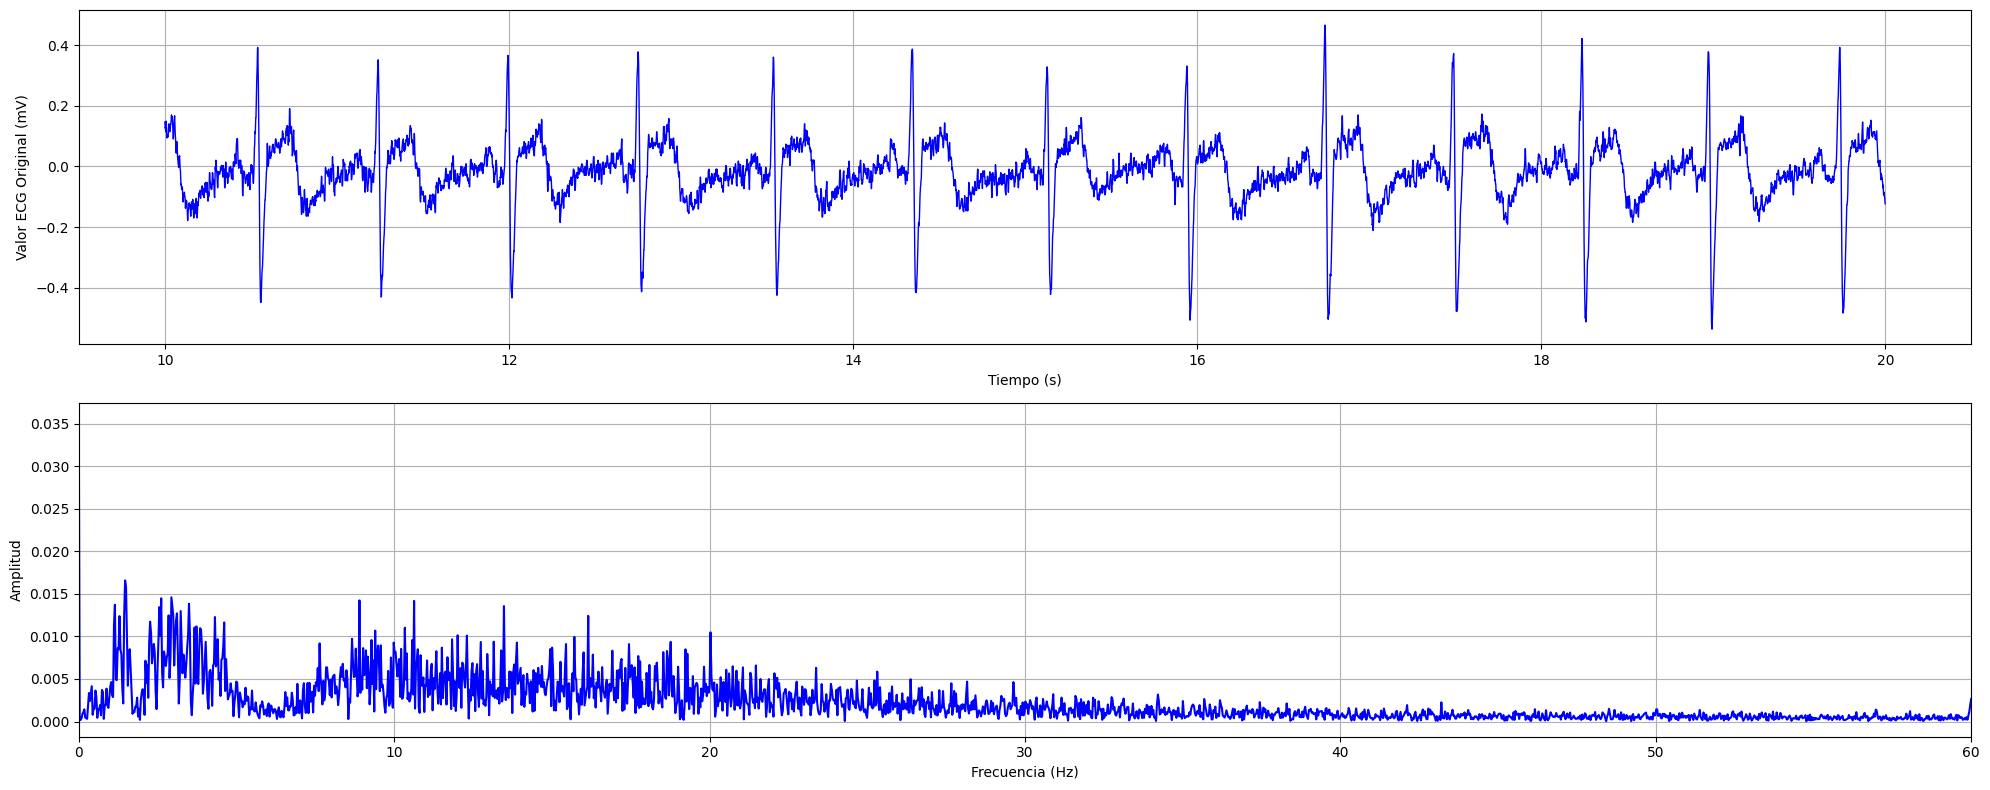

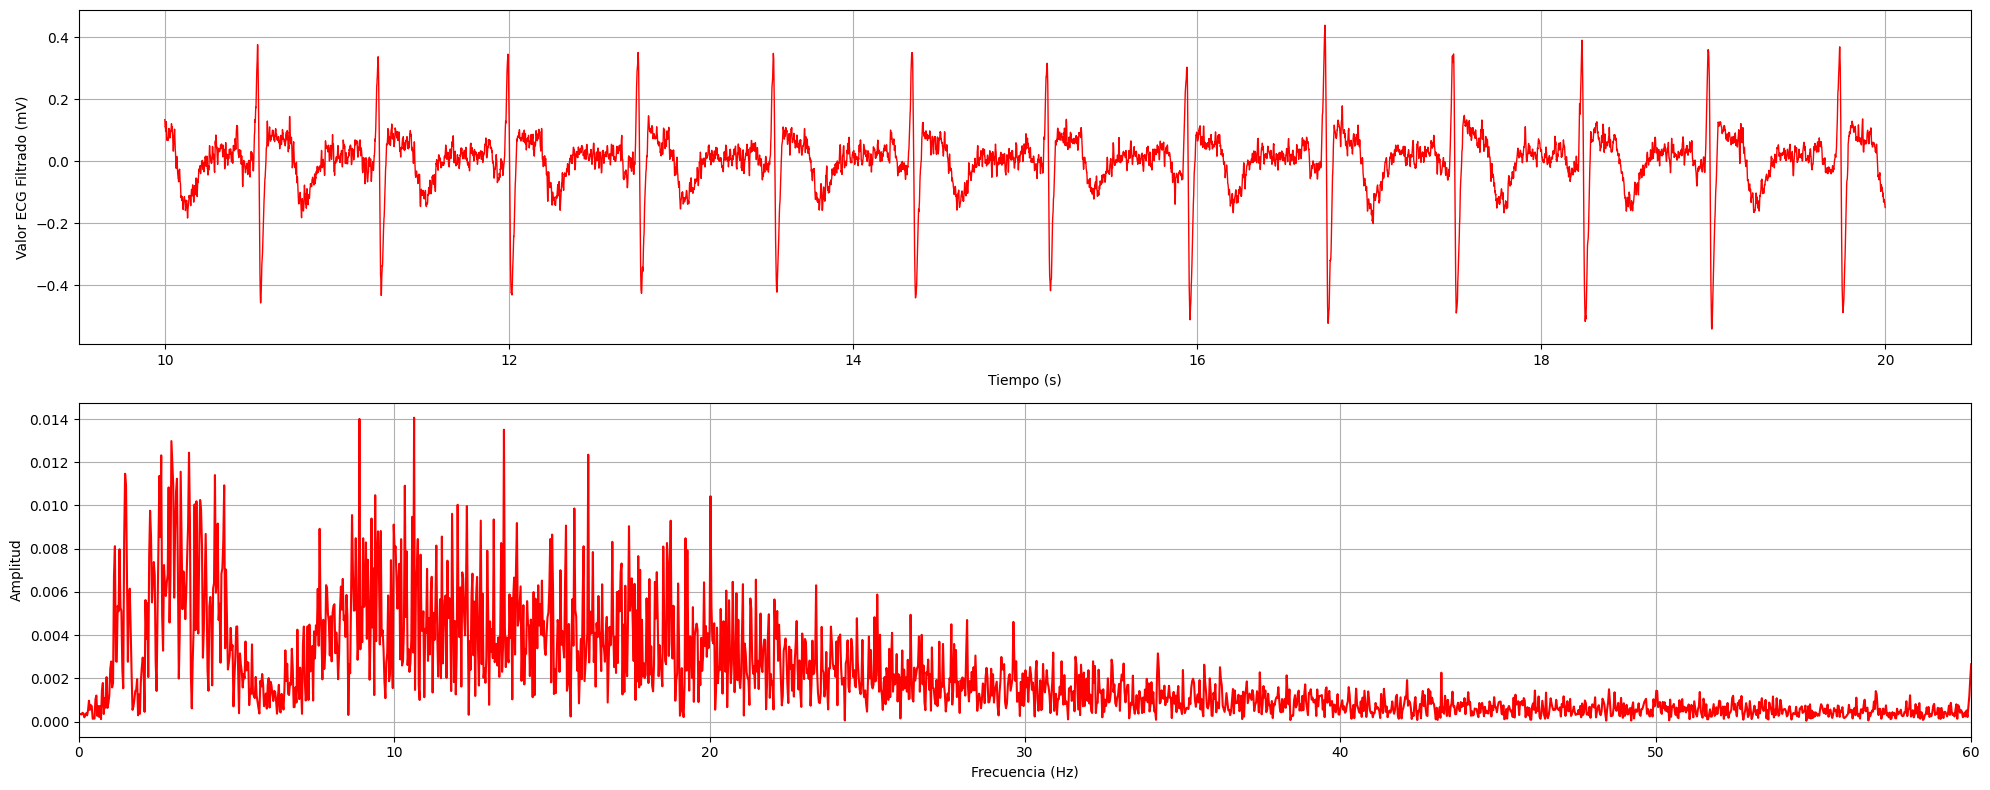

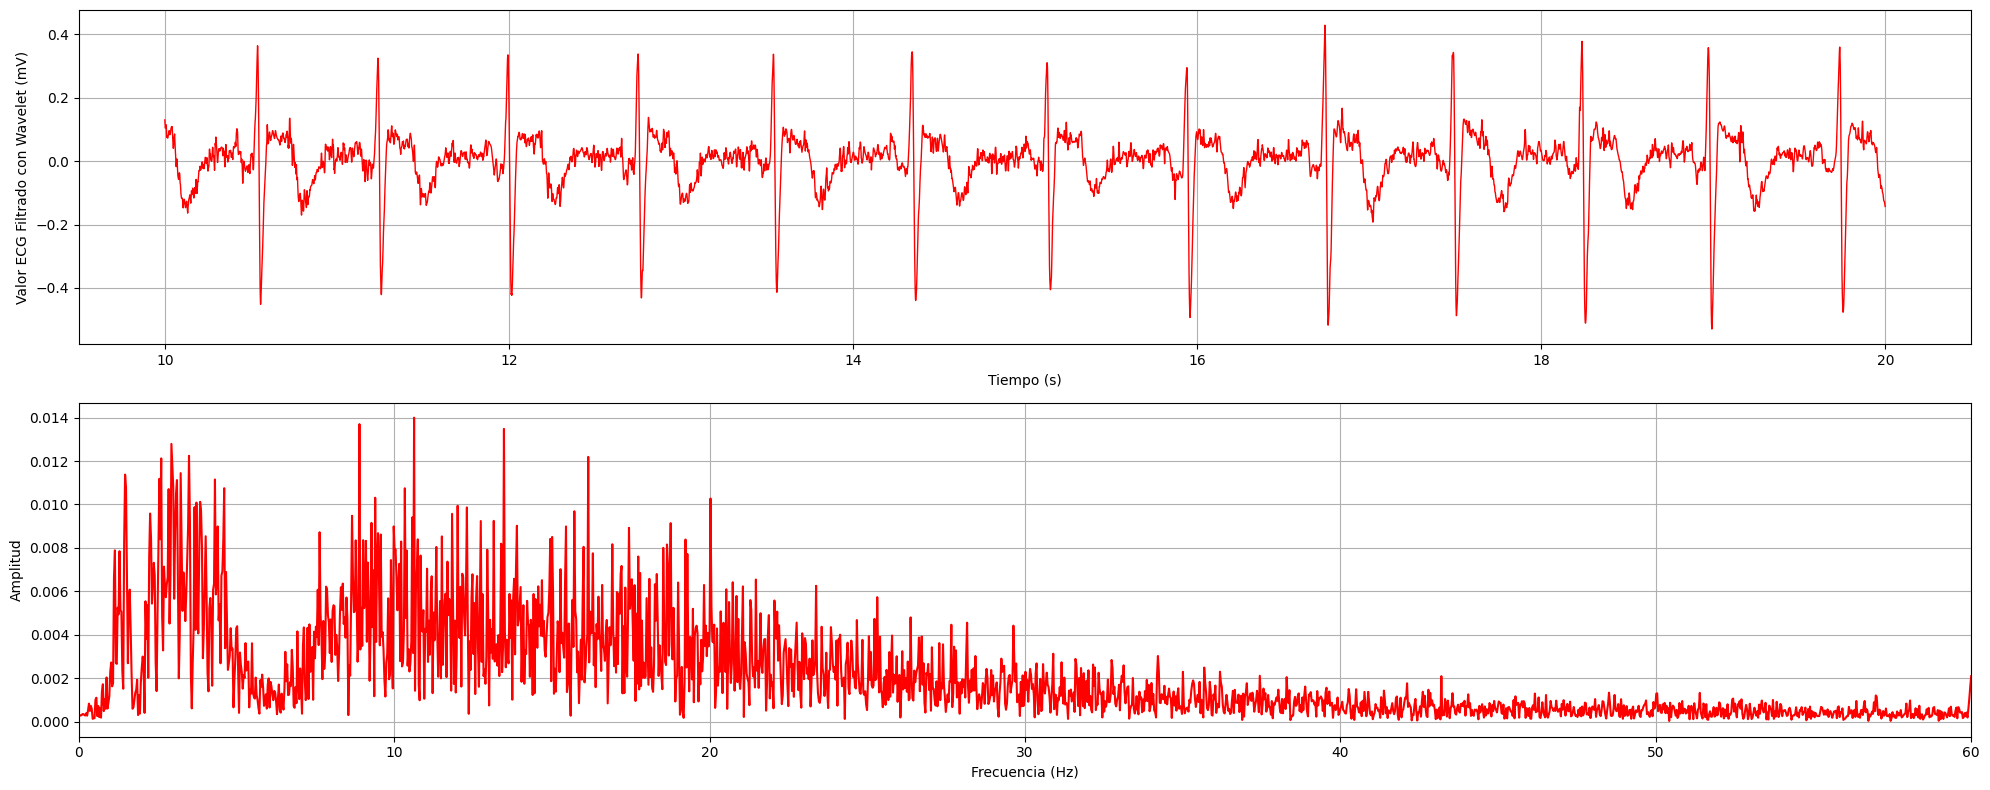

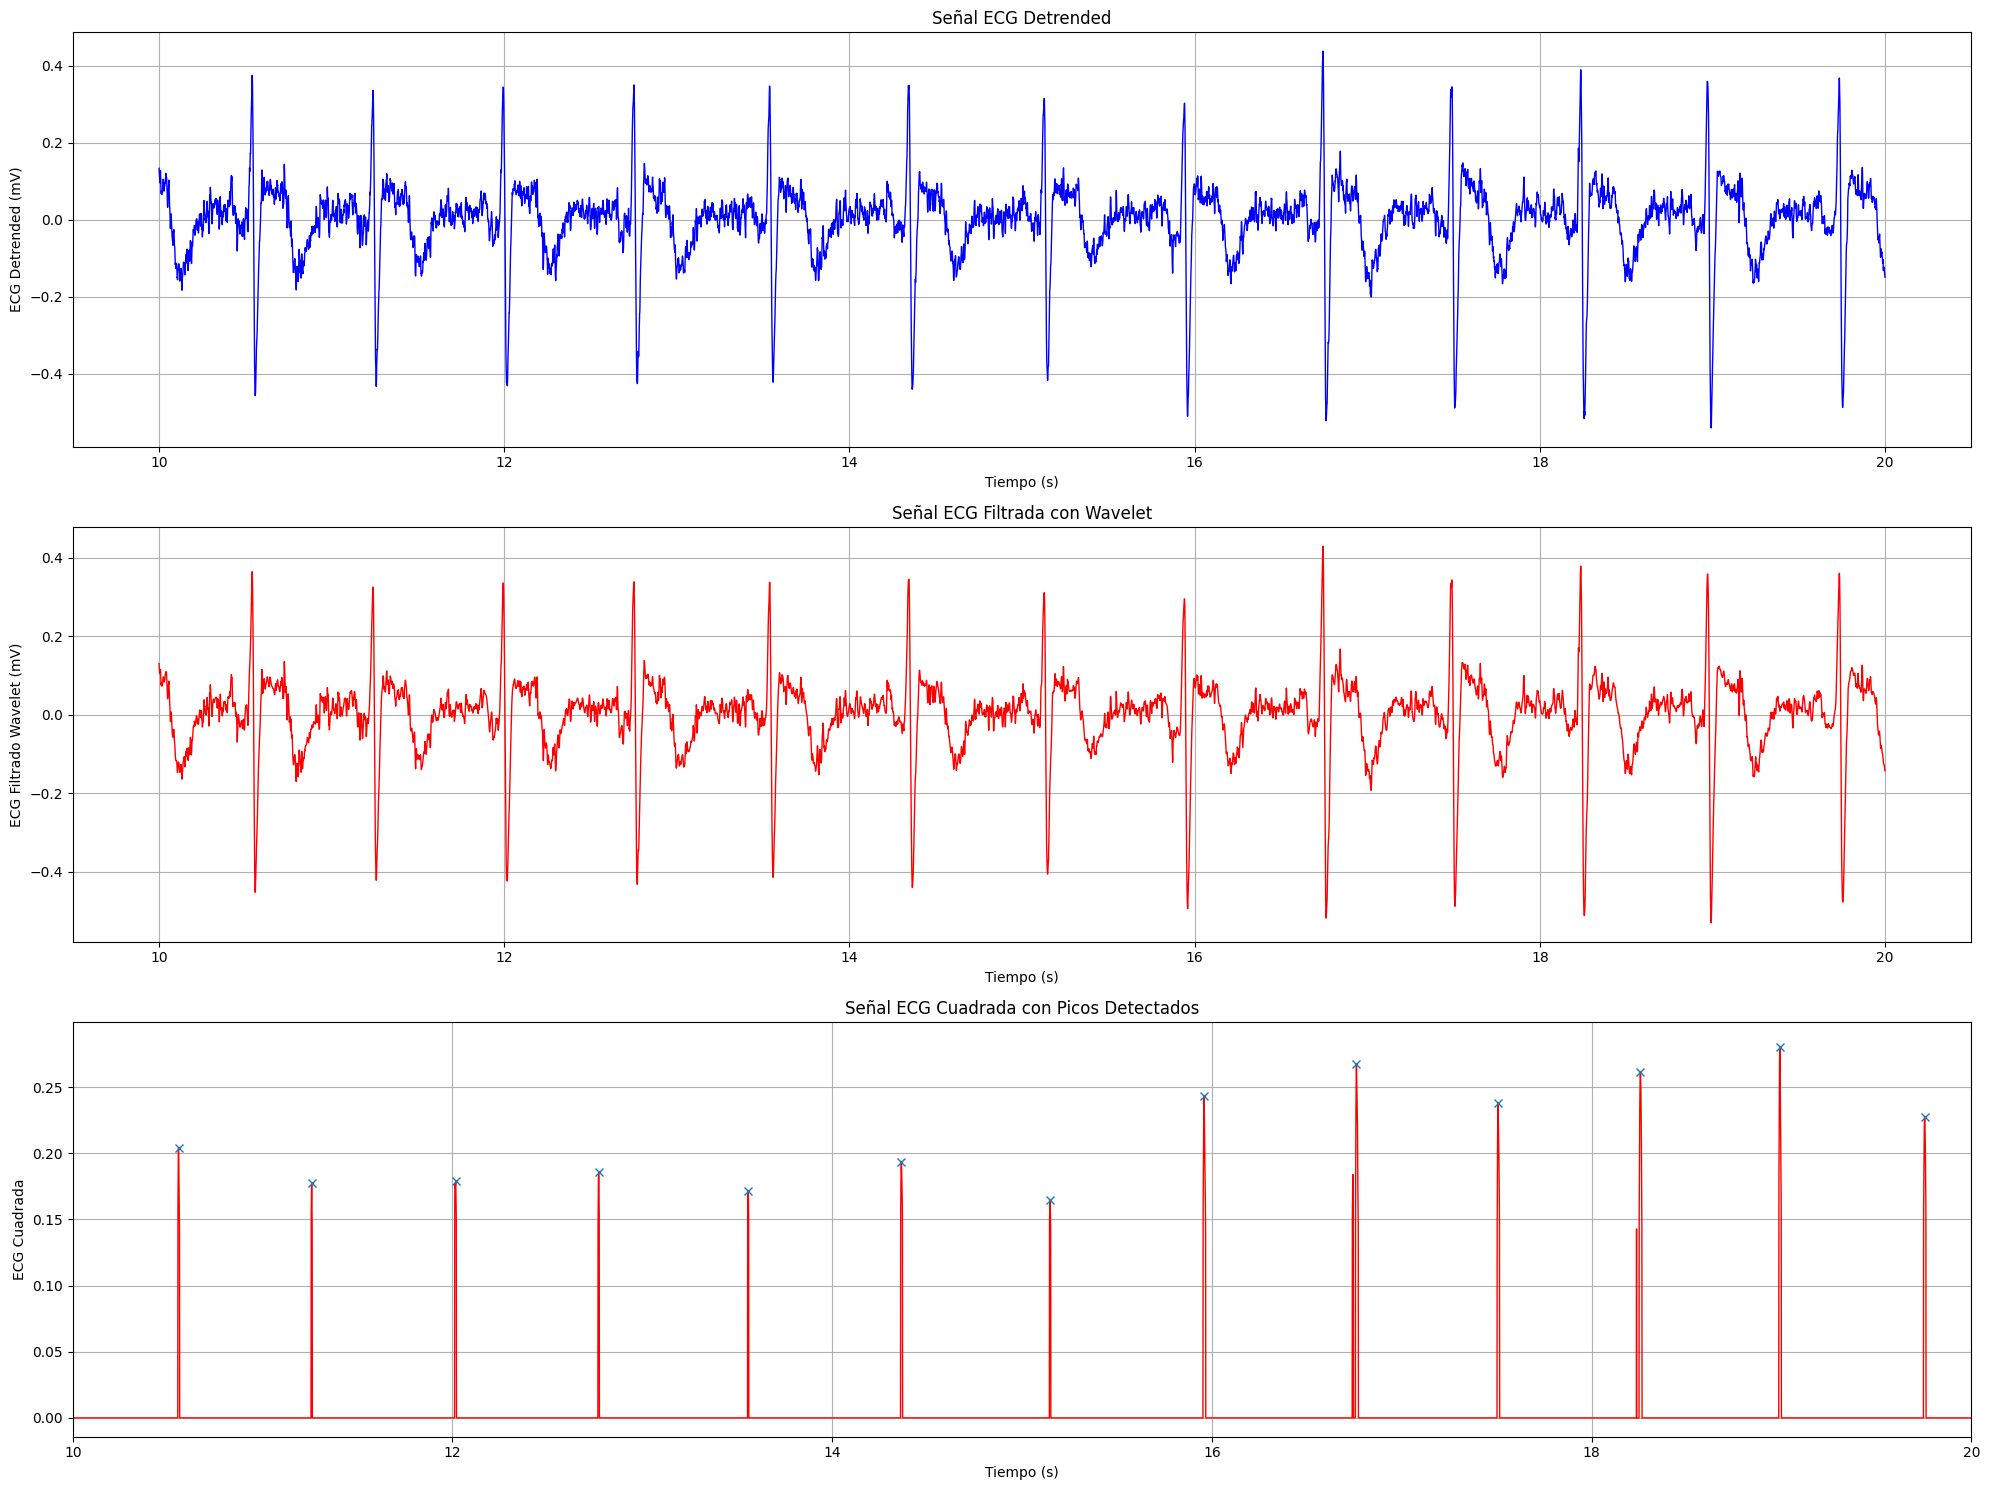

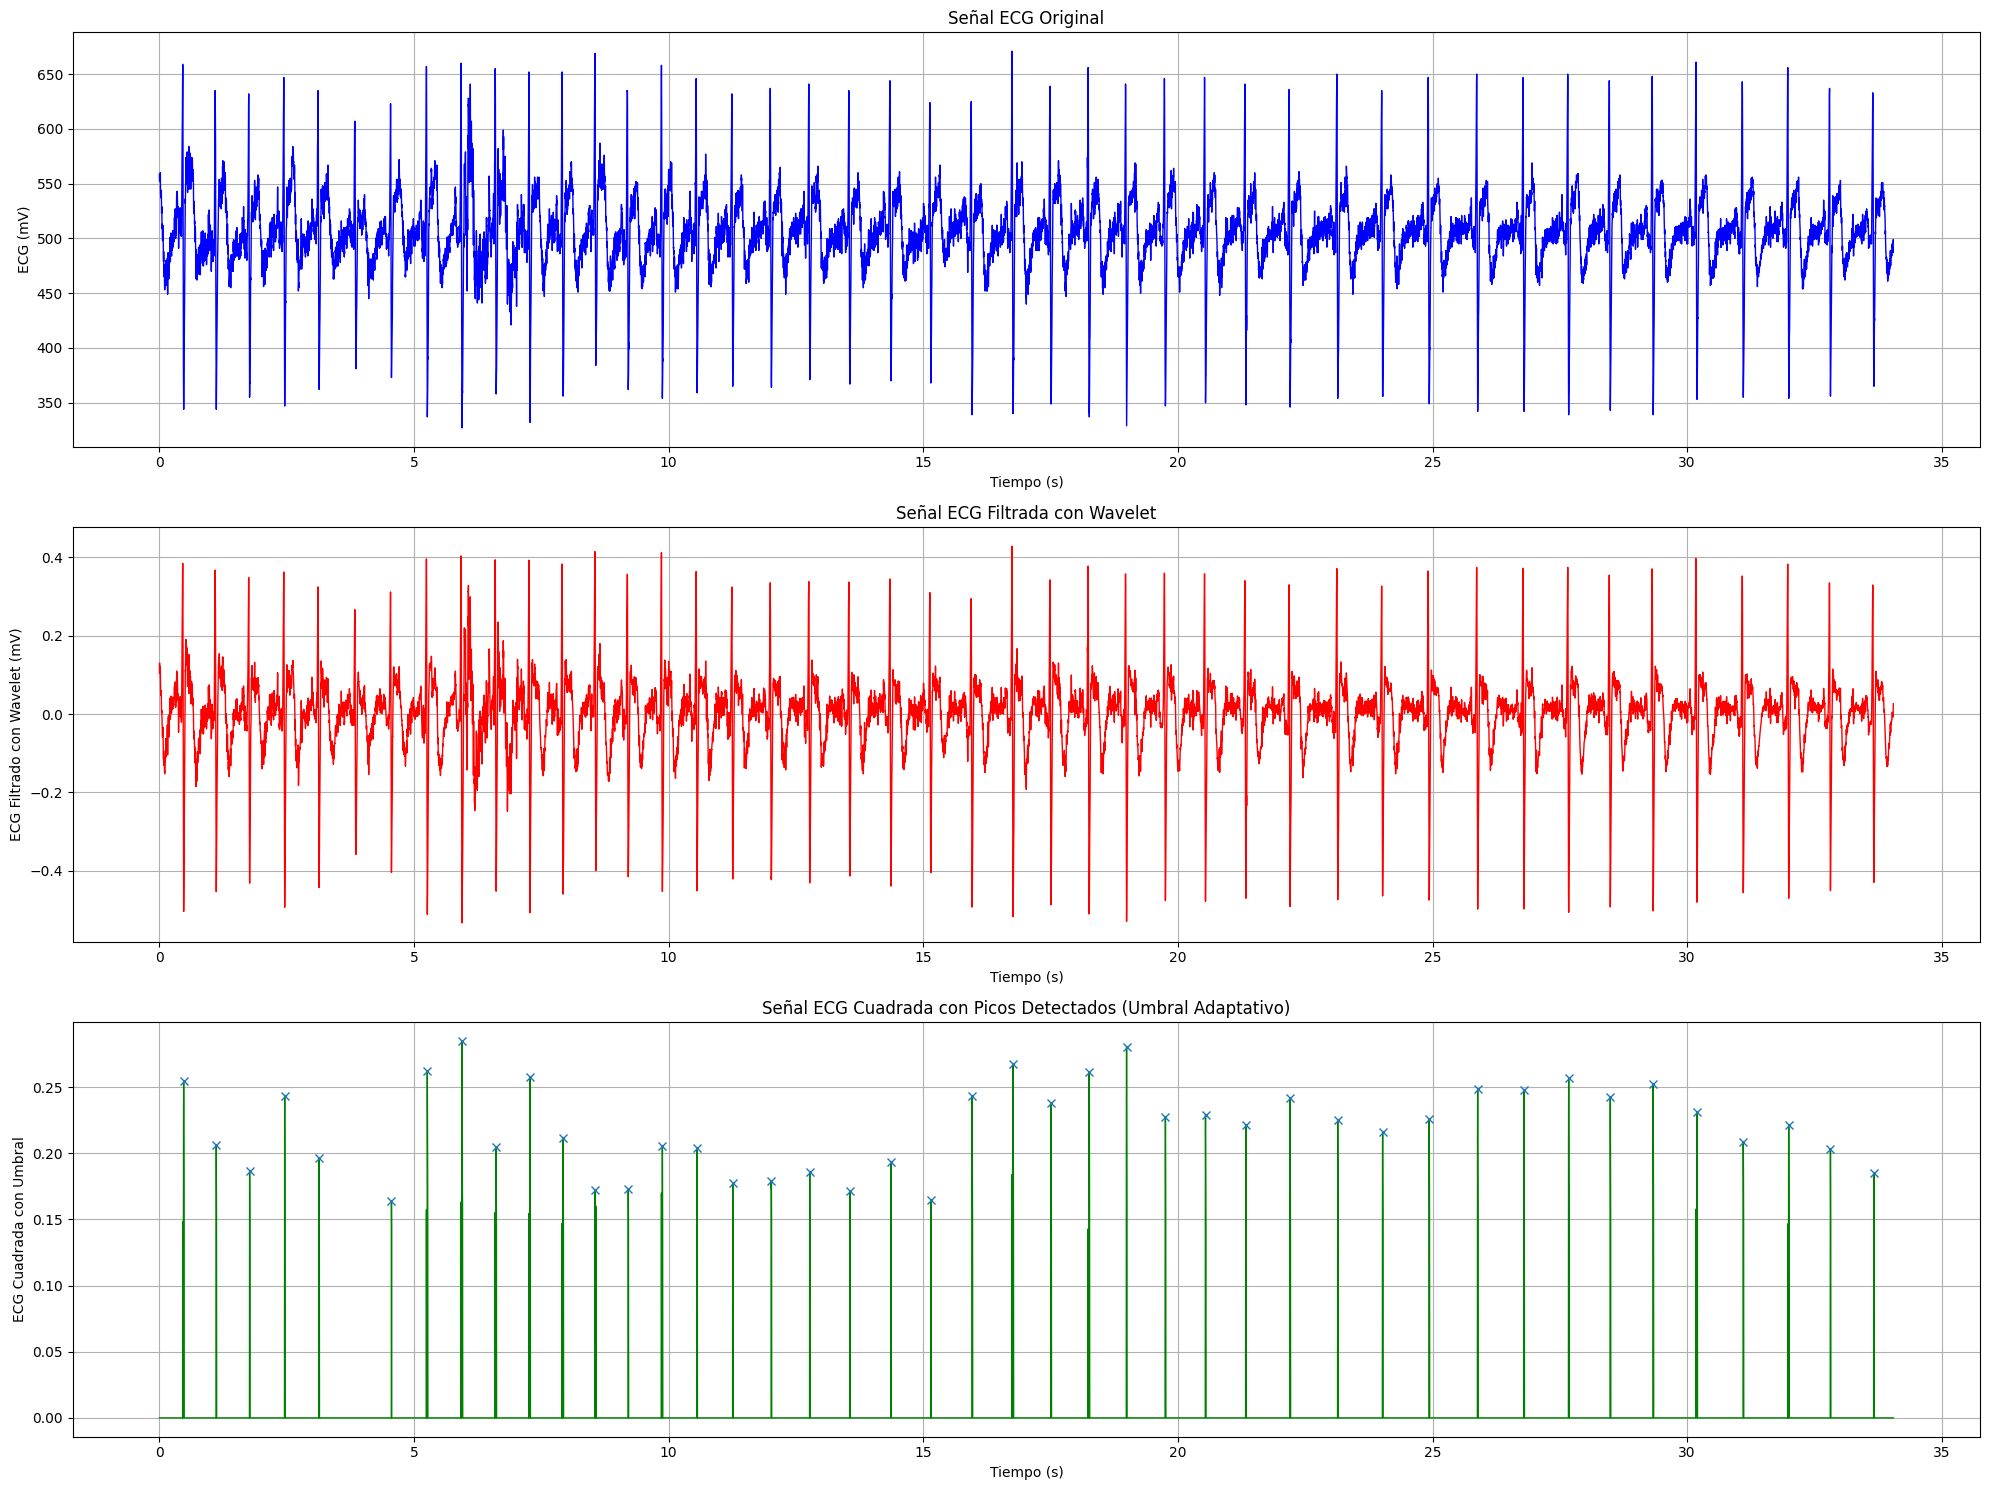

In [55]:
# leyendo archivo texto
archivo_txt = "ReposandoBurpee30s.txt"
datos_ecg = np.loadtxt(archivo_txt)
data = datos_ecg[:, 5]  # Sexta columna

# arreglo para los tiempos
frecuencia_muestreo = 1000
tiempo = np.arange(len(data)) / frecuencia_muestreo

# Intervalo de tiempo que visualizamos
inicio_segundo = 10
fin_segundo = 20
inicio_muestra = int(inicio_segundo * frecuencia_muestreo)
fin_muestra = int(fin_segundo * frecuencia_muestreo)

# Parámetros del BITalino
resolucion_adc = 1024
rango_voltaje = 3.0  # en mV
offset = resolucion_adc / 2

# Convertir los datos a mV
data_mv = ((data - offset) / resolucion_adc) * rango_voltaje

# Gráficos de las señales filtradas
plt.figure(figsize=(20, 8))
plt.subplot(2,1,1)
plt.plot(tiempo[inicio_muestra:fin_muestra], data_mv[inicio_muestra:fin_muestra], lw=1, color='blue')
plt.xlabel('Tiempo (s)')
plt.ylabel('Valor ECG Original (mV)')
plt.grid(True)

# Análisis en frecuencia con la Transformada de Fourier
N = len(data_mv)
T = 1.0 / frecuencia_muestreo

# Realizar la Transformada de Fourier
yf = fft(data_mv)
xf = fftfreq(N, T)[:N//2]

# Gráfica del espectro de frecuencias
plt.subplot(2,1,2)
plt.plot(xf, 2.0/N * np.abs(yf[:N//2]), color='blue')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Amplitud')
plt.grid(True)
plt.xlim(0, 60)  # Limitar el eje x de 0 a 60 Hz

plt.tight_layout()
plt.show()

# Aplicar filtro pasa altas DC-notch IIR de primer orden
alpha = 0.99
b = [(1 + alpha) / 2, -(1 + alpha) / 2]  # Coeficientes del numerador
a = [1, -alpha]  # Coeficientes del denominador

# Filtrar la señal
data_filtered = lfilter(b, a, data_mv)

# Gráficos de las señales filtradas
plt.figure(figsize=(20, 8))
plt.subplot(2,1,1)
plt.plot(tiempo[inicio_muestra:fin_muestra], data_filtered[inicio_muestra:fin_muestra], lw=1, color='red')
plt.xlabel('Tiempo (s)')
plt.ylabel('Valor ECG Filtrado (mV)')
plt.grid(True)

# Realizar la Transformada de Fourier
yf1 = fft(data_filtered)
xf1 = fftfreq(N, T)[:N//2]

# Gráfica del espectro de frecuencias
plt.subplot(2,1,2)
plt.plot(xf1, 2.0/N * np.abs(yf1[:N//2]), color='red')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Amplitud')
plt.grid(True)
plt.xlim(0, 60)  # Limitar el eje x de 0 a 60 Hz
plt.tight_layout()
plt.show()

# Aplicar la Transformada Wavelet Discreta (DWT) usando Daubechies-6 (db6)
coeffs = pywt.wavedec(data_filtered, 'db6', mode='per')

# Umbral adaptativo para atenuar sub-bandas de alta frecuencia
umbral_adaptativo = np.std(coeffs[-1]) * 2.5  # factor multiplicativo para que salga bonito :) text dice que lo ajuste
coeffs_filt = [pywt.threshold(c, umbral_adaptativo, mode='soft') for c in coeffs]

# Reconstruir la señal filtrada
data_wavelet_filtered = pywt.waverec(coeffs_filt, 'db6', mode='per')

# Gráficos de las señales filtradas
plt.figure(figsize=(20, 8))
plt.subplot(2,1,1)
plt.plot(tiempo[inicio_muestra:fin_muestra], data_wavelet_filtered[inicio_muestra:fin_muestra], lw=1, color='red')
plt.xlabel('Tiempo (s)')
plt.ylabel('Valor ECG Filtrado con Wavelet (mV)')
plt.grid(True)

# Realizar la Transformada de Fourier
yf2 = fft(data_wavelet_filtered)
xf2 = fftfreq(N, T)[:N//2]

# Gráfica del espectro de frecuencias
plt.subplot(2,1,2)
plt.plot(xf2, 2.0/N * np.abs(yf2[:N//2]), color='red')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Amplitud')
plt.grid(True)
plt.xlim(0, 60)  # Limitar el eje x de 0 a 60 Hz
plt.tight_layout()
plt.show()


# square de la señal
data_squared = np.square(data_wavelet_filtered)

# Aplicar umbral adaptativo
umbral_aplicado = np.max(data_squared) * 0.5  # Por ejemplo, supongamos un umbral del 50% de la amplitud máxima
data_squared_umbral = data_squared * (data_squared > umbral_aplicado)

# Detección de picos con umbral adaptativo
peaks, _ = find_peaks(data_squared_umbral, distance=150)  # Ajustar distancia mínima entre picos

# Gráficos de la señal original, filtrada y cuadrada con detección de picos
plt.figure(figsize=(20, 15))

plt.subplot(3, 1, 1)
plt.plot(tiempo[inicio_muestra:fin_muestra], data_filtered[inicio_muestra:fin_muestra], lw=1, color='blue')
plt.xlabel('Tiempo (s)')
plt.ylabel('ECG Detrended (mV)')
plt.title('Señal ECG Detrended')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(tiempo[inicio_muestra:fin_muestra], data_wavelet_filtered[inicio_muestra:fin_muestra], lw=1, color='red')
plt.xlabel('Tiempo (s)')
plt.ylabel('ECG Filtrado Wavelet (mV)')
plt.title('Señal ECG Filtrada con Wavelet')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(tiempo[inicio_muestra:fin_muestra], data_squared_umbral[inicio_muestra:fin_muestra], lw=1, color='red')
plt.plot(tiempo[peaks], data_squared_umbral[peaks], "x")
plt.xlabel('Tiempo (s)')
plt.ylabel('ECG Cuadrada')
plt.title('Señal ECG Cuadrada con Picos Detectados')
plt.grid(True)
plt.xlim(10, 20)

plt.tight_layout()
plt.show()

# Cálculo de la señal de intervalos RR
RR_intervals = np.diff(peaks) / frecuencia_muestreo

# Cálculo de HRV utilizando cubic spline interpolation
tiempo_interpolado = np.arange(tiempo[0], tiempo[-1], 1 / frecuencia_muestreo)
RR_interpolado = np.interp(tiempo_interpolado, tiempo[peaks[:-1]], RR_intervals)
HRV = np.diff(RR_interpolado)

# Gráficos de la señal original, filtrada y cuadrada con detección de picos
plt.figure(figsize=(20, 15))
plt.subplot(3, 1, 1)
plt.plot(tiempo, data, lw=1, color='blue')
plt.xlabel('Tiempo (s)')
plt.ylabel('ECG (mV)')
plt.title('Señal ECG Original')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(tiempo, data_wavelet_filtered, lw=1, color='red')
plt.xlabel('Tiempo (s)')
plt.ylabel('ECG Filtrado con Wavelet (mV)')
plt.title('Señal ECG Filtrada con Wavelet')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(tiempo, data_squared_umbral, lw=1, color='green')
plt.plot(tiempo[peaks], data_squared_umbral[peaks], "x")
plt.xlabel('Tiempo (s)')
plt.ylabel('ECG Cuadrada con Umbral')
plt.title('Señal ECG Cuadrada con Picos Detectados (Umbral Adaptativo)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [56]:
#ahora para evaluar a la persona
# Calcular RMSSD
RMSSD = np.sqrt(np.mean(np.diff(RR_intervals) ** 2))

# Calcular SDNN
SDNN = np.std(RR_intervals)

# Calcular PNN50
PNN50 = np.sum(np.diff(RR_intervals) > 0.05) / len(RR_intervals) * 100

print("RMSSD:", RMSSD, "s")
print("SDNN:", SDNN, "s")
print("PNN50:", PNN50, "%")

RMSSD: 0.16539988497946276 s
SDNN: 0.13455044826849036 s
PNN50: 9.523809523809524 %
